# British Sign Language (BSL)

# Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Uploadind an Unziping the Dataset

In [ ]:
'''import os

dataset_path = "/content/BSL_Dataset"

# Checking if dataset is already extracted
if not os.path.exists(dataset_path):
    print("Dataset not found. Downloading and extracting...")

    # Ensuring Kaggle credentials are set up
    os.makedirs("/root/.kaggle", exist_ok=True)
    !mv /content/kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

    # Download dataset
    !kaggle datasets download -d drmabroukaabuhmida/bsl-dataset-credits-to-eren-tatepe

    # Extracting dataset
    !unzip -q bsl-dataset-credits-to-eren-tatepe.zip -d BSL_Dataset
else:
    print("Dataset already exists. Skipping download.")

# Verifying dataset structure
print("Dataset contents:", os.listdir(dataset_path))

'''

'import os\n\ndataset_path = "/content/BSL_Dataset"\n\n# Check if dataset is already extracted\nif not os.path.exists(dataset_path):\n    print("Dataset not found. Downloading and extracting...")\n\n    # Ensure Kaggle credentials are set up\n    os.makedirs("/root/.kaggle", exist_ok=True)\n    !mv /content/kaggle.json /root/.kaggle/\n    !chmod 600 /root/.kaggle/kaggle.json\n\n    # Download dataset\n    !kaggle datasets download -d drmabroukaabuhmida/bsl-dataset-credits-to-eren-tatepe\n\n    # Extract dataset\n    !unzip -q bsl-dataset-credits-to-eren-tatepe.zip -d BSL_Dataset\nelse:\n    print("Dataset already exists. Skipping download.")\n\n# Verify dataset structure\nprint("Dataset contents:", os.listdir(dataset_path))\n\n'

# Loading the Libraries

In [ ]:
import os
import numpy as np
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import collections
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential
from google.colab import drive
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score

# Checking the main dataset structure

In [ ]:
# Define the dataset root path
dataset_path = "/content/drive/MyDrive/BSL_Dataset"

# Checking folder structure
for main_folder in os.listdir(dataset_path):
    main_folder_path = os.path.join(dataset_path, main_folder)
    print(f"\n{main_folder}:")  # Main category (1_HAND_DATASET or 2_HAND_DATASET)

    if os.path.isdir(main_folder_path):
        for sub_folder in os.listdir(main_folder_path):
            sub_folder_path = os.path.join(main_folder_path, sub_folder)
            print(f"  ├── {sub_folder}")  # Subfolder (categories, e.g., "Five - 5")

            if os.path.isdir(sub_folder_path):
                sample_files = os.listdir(sub_folder_path)[:5]  # Show first 5 files
                print(f"    ├── Sample files: {sample_files}")


bsl-dataset-credits-to-eren-tatepe.zip:

1_HAND_DATASET:
  ├── 1_HAND_DATASET
    ├── Sample files: ['C - c', 'Eight - 8', 'Five - 5', 'Four - 4', 'Nine - 9']

2_HAND_DATASET:
  ├── 2_HAND_DATASET
    ├── Sample files: ['A - a', 'B - b', 'D - d', 'E - e', 'F - f']


# Dataset Paths

In [ ]:
# Setting paths to actual image folders
one_hand_dataset = os.path.join(dataset_path, "1_HAND_DATASET", "1_HAND_DATASET")
two_hand_dataset = os.path.join(dataset_path, "2_HAND_DATASET", "2_HAND_DATASET")

print("1-Hand dataset path:", one_hand_dataset)
print("2-Hand dataset path:", two_hand_dataset)

# Selecting a random class from the dataset
random_class = random.choice(os.listdir(one_hand_dataset))
class_path = os.path.join(one_hand_dataset, random_class)

print(f"Selected class: {random_class}")
print(f"Path to images: {class_path}")

# Listing sample files from the selected class
sample_files = os.listdir(class_path)[:5]
print(f"Sample images: {sample_files}")

1-Hand dataset path: /content/drive/MyDrive/BSL_Dataset/1_HAND_DATASET/1_HAND_DATASET
2-Hand dataset path: /content/drive/MyDrive/BSL_Dataset/2_HAND_DATASET/2_HAND_DATASET
Selected class: Six - 6
Path to images: /content/drive/MyDrive/BSL_Dataset/1_HAND_DATASET/1_HAND_DATASET/Six - 6
Sample images: ['10.png', '1015.png', '100.png', '1005.png', '1020.png']


# Loading & Displaying Images

Found 34000 image files.


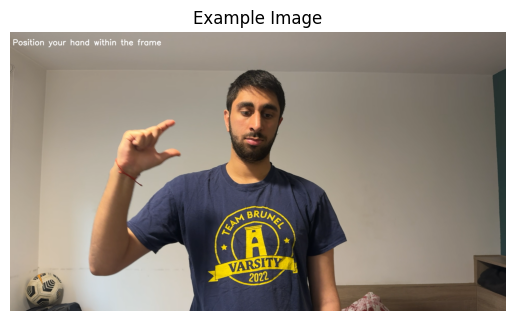

In [ ]:
# Selecting a sample image
image_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} image files.")

if image_files:
    sample_image_path = image_files[0]
    image = cv2.imread(sample_image_path)
    if image is not None:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Example Image")
        plt.show()
    else:
        print("Error: Could not load the image file.")

# Resizing & Normalizing Images

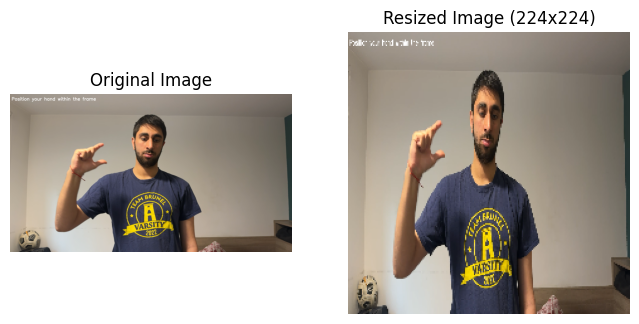

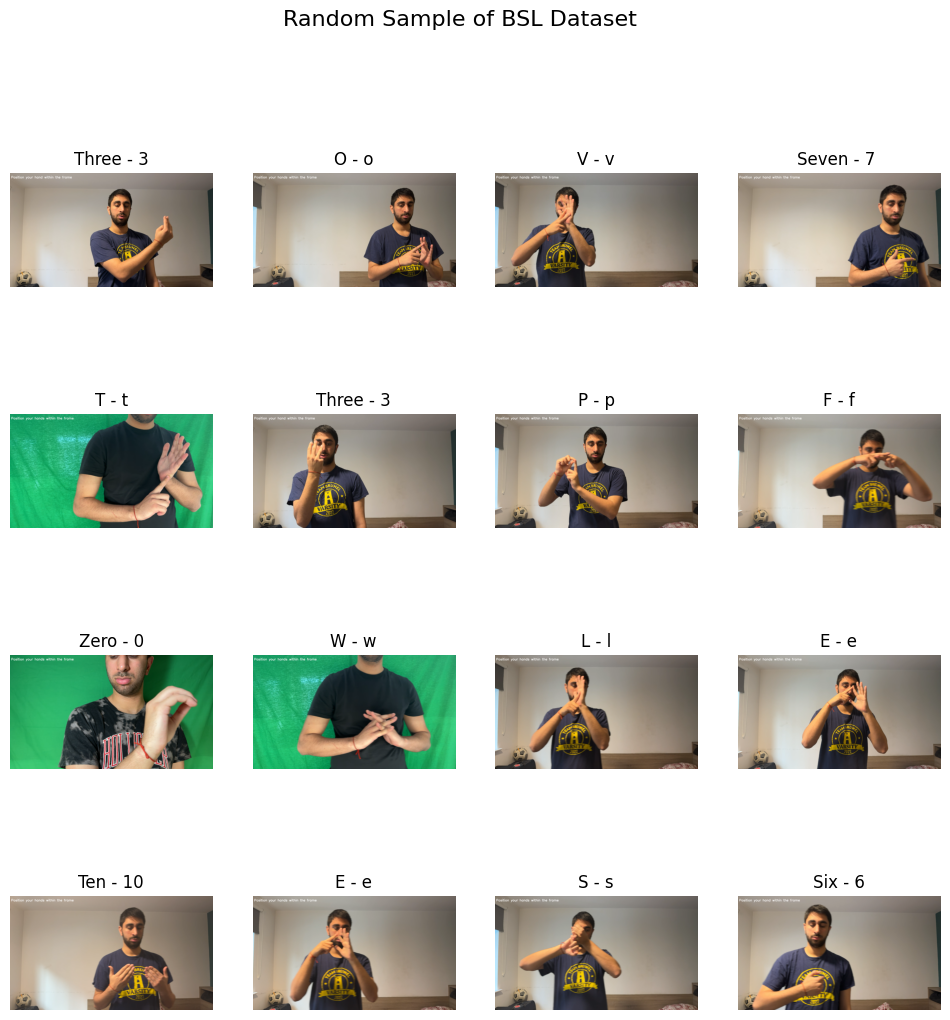

In [ ]:
# Defining the new target image size
IMG_SIZE = (224, 224)

def load_and_preprocess_images(image_paths, img_size=(224, 224)):
    """Loads, resizes, and normalizes one or multiple images."""
    frames = []

    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not load {image_path}. Skipping.")
            continue
        img = cv2.resize(img, img_size)
        img = img.astype("float32") / 255.0  # Normalize to [0,1]
        frames.append(img)

    return np.array(frames)

# Selecting a sample image
sample_image_path = image_files[0]  # Selecting the first image
original_img_array = load_and_preprocess_images([sample_image_path])  # Use list as input
original_img = cv2.imread(sample_image_path)  # Load original image separately
resized_img = original_img_array[0]  # Extract first image from processed batch

# Displaying original vs resized image
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Resized Image (224x224)")

plt.show()

# Selecting random images from dataset
random_images = random.sample(image_files, 16)

# Plotting images in a 4x4 grid
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(random_images):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting BGR to RGB

    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(img_path.split("/")[-2])  # Displaying class name

plt.suptitle("Random Sample of BSL Dataset", fontsize=16)
plt.show()

# Checking Class Distribution

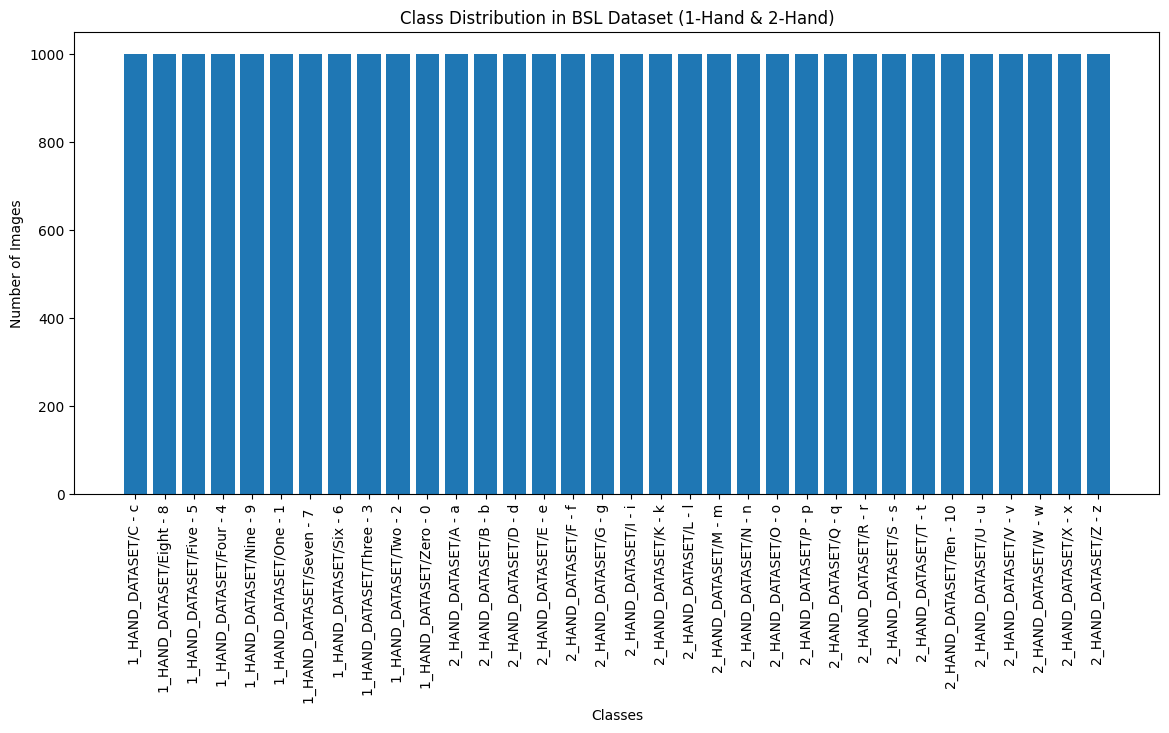

1_HAND_DATASET/C - c: 1000 images
1_HAND_DATASET/Eight - 8: 1000 images
1_HAND_DATASET/Five - 5: 1000 images
1_HAND_DATASET/Four - 4: 1000 images
1_HAND_DATASET/Nine - 9: 1000 images
1_HAND_DATASET/One - 1: 1000 images
1_HAND_DATASET/Seven - 7 : 1000 images
1_HAND_DATASET/Six - 6: 1000 images
1_HAND_DATASET/Three - 3: 1000 images
1_HAND_DATASET/Two - 2: 1000 images
1_HAND_DATASET/Zero - 0: 1000 images
2_HAND_DATASET/A - a: 1000 images
2_HAND_DATASET/B - b: 1000 images
2_HAND_DATASET/D - d: 1000 images
2_HAND_DATASET/E - e: 1000 images
2_HAND_DATASET/F - f: 1000 images
2_HAND_DATASET/G - g: 1000 images
2_HAND_DATASET/I - i: 1000 images
2_HAND_DATASET/K - k: 1000 images
2_HAND_DATASET/L - l: 1000 images
2_HAND_DATASET/M - m: 1000 images
2_HAND_DATASET/N - n: 1000 images
2_HAND_DATASET/O - o: 1000 images
2_HAND_DATASET/P - p: 1000 images
2_HAND_DATASET/Q - q: 1000 images
2_HAND_DATASET/R - r: 1000 images
2_HAND_DATASET/S - s: 1000 images
2_HAND_DATASET/T - t: 1000 images
2_HAND_DATASET/Te

In [ ]:
# Counting images per class
class_counts = collections.Counter()

for main_folder in os.listdir(dataset_path):
    main_folder_path = os.path.join(dataset_path, main_folder)
    if os.path.isdir(main_folder_path):
        for sub_folder in os.listdir(main_folder_path):
            sub_folder_path = os.path.join(main_folder_path, sub_folder)
            if os.path.isdir(sub_folder_path):
                for class_folder in os.listdir(sub_folder_path):
                    class_path = os.path.join(sub_folder_path, class_folder)
                    if os.path.isdir(class_path):
                        class_counts[f"{main_folder}/{class_folder}"] = len(os.listdir(class_path))

# Sorting classes by number of images
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Plotting class distribution
plt.figure(figsize=(14, 6))
plt.bar([x[0] for x in sorted_classes], [x[1] for x in sorted_classes])
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in BSL Dataset (1-Hand & 2-Hand)")
plt.show()

# Printing summary
for class_name, count in sorted_classes:
    print(f"{class_name}: {count} images")

In [ ]:
# Defining paths to the one-hand and two-hand datasets
one_hand_dataset = os.path.join(dataset_path, "1_HAND_DATASET", "1_HAND_DATASET")
two_hand_dataset = os.path.join(dataset_path, "2_HAND_DATASET", "2_HAND_DATASET")

def list_classes(dataset_folder, dataset_name):
    """Lists the available classes in the dataset folder."""
    if os.path.exists(dataset_folder):
        print(f"\nChecking classes in {dataset_name}...")
        classes = os.listdir(dataset_folder)
        print(f"   Found {len(classes)} classes. Example class names:")
        print("   ", classes[:10])  # Displaying the first 10 class names
    else:
        print(f"Folder {dataset_folder} does not exist. Verify the path.")

# Displaying available classes for both datasets
list_classes(one_hand_dataset, "1-Hand Dataset")
list_classes(two_hand_dataset, "2-Hand Dataset")


Checking classes in 1-Hand Dataset...
   Found 11 classes. Example class names:
    ['C - c', 'Eight - 8', 'Five - 5', 'Four - 4', 'Nine - 9', 'One - 1', 'Seven - 7 ', 'Six - 6', 'Three - 3', 'Two - 2']

Checking classes in 2-Hand Dataset...
   Found 23 classes. Example class names:
    ['A - a', 'B - b', 'D - d', 'E - e', 'F - f', 'G - g', 'I - i', 'K - k', 'L - l', 'M - m']


# Checking Sequences of Gestures

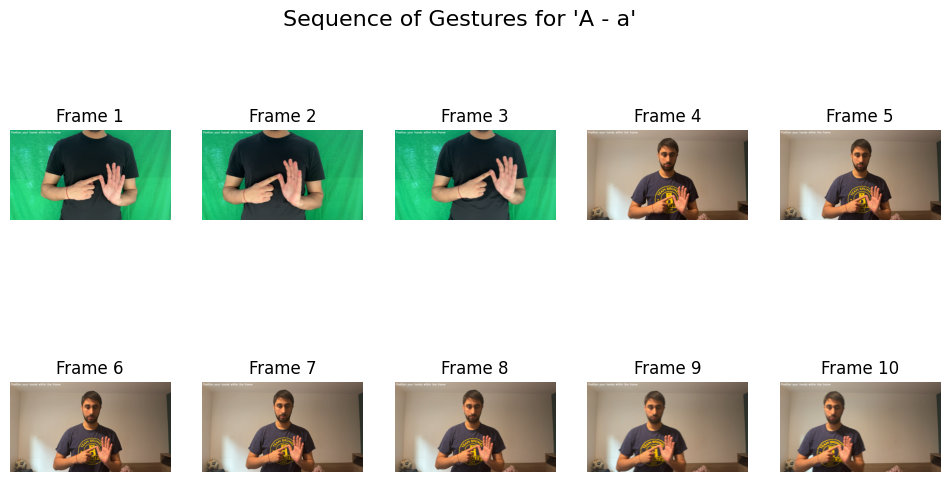

In [ ]:
# Selecting a class for sequence analysis
selected_class = "A - a"  # class "A - a"

# Determine if the class is in the one-hand or two-hand dataset
if selected_class in os.listdir(one_hand_dataset):
    selected_class_path = os.path.join(one_hand_dataset, selected_class)
elif selected_class in os.listdir(two_hand_dataset):
    selected_class_path = os.path.join(two_hand_dataset, selected_class)
else:
    raise ValueError(f"Class '{selected_class}' not found in the dataset.")

# Getting image file names sorted by order
image_files = sorted(os.listdir(selected_class_path))[:10]  # Loading first 10 images

# Displaying sequence of images
plt.figure(figsize=(12, 6))
for i, img_file in enumerate(image_files):
    img_path = os.path.join(selected_class_path, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converting BGR to RGB for correct visualization

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Frame {i+1}")

plt.suptitle(f"Sequence of Gestures for '{selected_class}'", fontsize=16)
plt.show()

# Comparison of Frame Differences for BSL Gestures

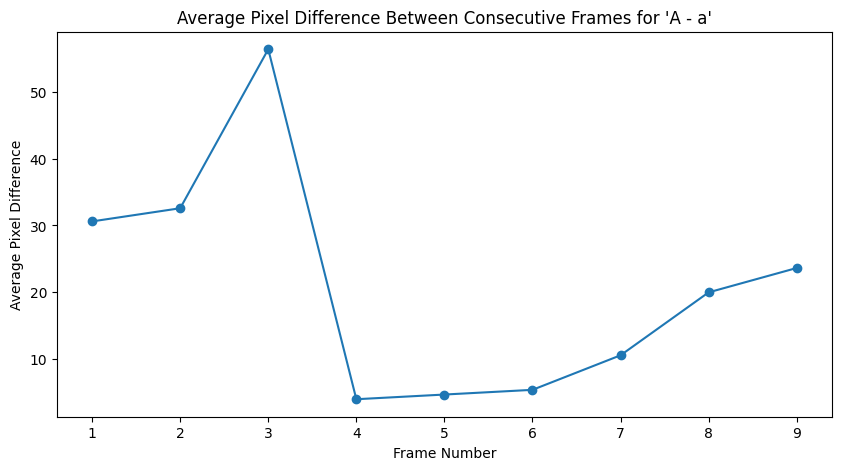

Class: A - a
Mean Difference: 20.83
Max Difference: 56.45
Min Difference: 3.90


In [ ]:
# Selecting a class for analysis
selected_class = "A - a"  # class "A - a"

# Defineing the dataset path
dataset_path = "/content/drive/MyDrive/BSL_Dataset/2_HAND_DATASET/2_HAND_DATASET"

# Defineing path to selected class
selected_class_path = os.path.join(dataset_path, selected_class)

if not os.path.exists(selected_class_path):
    print(f"Folder {selected_class_path} does not exist! Check class name.")
else:
    # List and sort images in the class folder
    image_files = sorted([f for f in os.listdir(selected_class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    # Loading images into an array
    images = []
    for img_file in image_files[:10]:  # Limit to first 10 frames for speed
        img_path = os.path.join(selected_class_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = cv2.resize(img, (224, 224))  # Resize to standard size
        images.append(img)

    images = np.array(images)

    # Compute frame differences
    differences = []
    for i in range(len(images) - 1):
        diff = np.abs(images[i].astype(np.float32) - images[i + 1].astype(np.float32))
        differences.append(np.mean(diff))  # Compute mean pixel difference

    # Plotting the frame differences
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(differences) + 1), differences, marker='o', linestyle='-')
    plt.xlabel("Frame Number")
    plt.ylabel("Average Pixel Difference")
    plt.title(f"Average Pixel Difference Between Consecutive Frames for '{selected_class}'")
    plt.show()

    # Printing statistics
    print(f"Class: {selected_class}")
    print(f"Mean Difference: {np.mean(differences):.2f}")
    print(f"Max Difference: {np.max(differences):.2f}")
    print(f"Min Difference: {np.min(differences):.2f}")

# Comparison of Frame Differences for BSL Gestures between classes

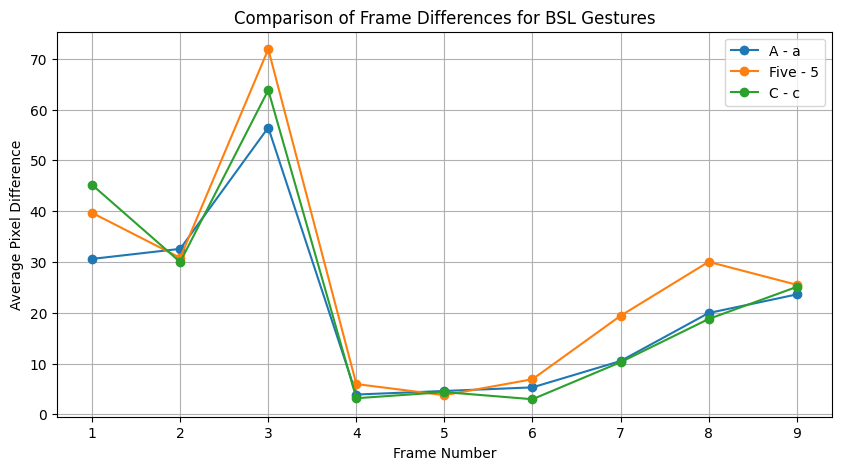

Class: A - a
Mean Difference: 20.83
Max Difference: 56.45
Min Difference: 3.90
----------------------------------------
Class: Five - 5
Mean Difference: 25.99
Max Difference: 71.88
Min Difference: 3.78
----------------------------------------
Class: C - c
Mean Difference: 22.63
Max Difference: 63.82
Min Difference: 2.98
----------------------------------------


In [ ]:
# Defining dataset paths for both 1-hand and 2-hand gestures
dataset_paths = {
    "1-Hand": "/content/drive/MyDrive/BSL_Dataset/1_HAND_DATASET/1_HAND_DATASET",
    "2-Hand": "/content/drive/MyDrive/BSL_Dataset/2_HAND_DATASET/2_HAND_DATASET",
}

# Classes to compare (from both datasets)
selected_classes = {
    "A - a": "2-Hand",
    "Five - 5": "1-Hand",
    "C - c": "1-Hand"
}

# Function to compute average pixel differences between frames
def compute_frame_differences(class_name, dataset_type):
    class_path = os.path.join(dataset_paths[dataset_type], class_name)

    if not os.path.exists(class_path):
        print(f"Class '{class_name}' not found in {dataset_type} dataset!")
        return None

    # Geting sorted list of image files
    image_files = sorted([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) < 2:
        print(f"Not enough images for class '{class_name}' in {dataset_type} dataset!")
        return None

    # Loading images
    images = []
    for img_file in image_files[:10]:  # Limit to first 10 frames
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        images.append(img)

    images = np.array(images)

    # Computing pixel differences
    differences = []
    for i in range(len(images) - 1):
        diff = np.abs(images[i].astype(np.float32) - images[i + 1].astype(np.float32))
        differences.append(np.mean(diff))

    return differences

# Storing results for all classes
class_differences = {}
for class_name, dataset_type in selected_classes.items():
    differences = compute_frame_differences(class_name, dataset_type)
    if differences:
        class_differences[class_name] = differences

# Plotting results
plt.figure(figsize=(10, 5))
for class_name, differences in class_differences.items():
    plt.plot(range(1, len(differences) + 1), differences, marker='o', linestyle='-', label=class_name)

plt.xlabel("Frame Number")
plt.ylabel("Average Pixel Difference")
plt.title("Comparison of Frame Differences for BSL Gestures")
plt.legend()
plt.grid()
plt.show()

# Displaying statistics for each class
for class_name, differences in class_differences.items():
    print(f"Class: {class_name}")
    print(f"Mean Difference: {np.mean(differences):.2f}")
    print(f"Max Difference: {np.max(differences):.2f}")
    print(f"Min Difference: {np.min(differences):.2f}")
    print("-" * 40)

Comparison of Frame Differences for BSL Gestures between hands

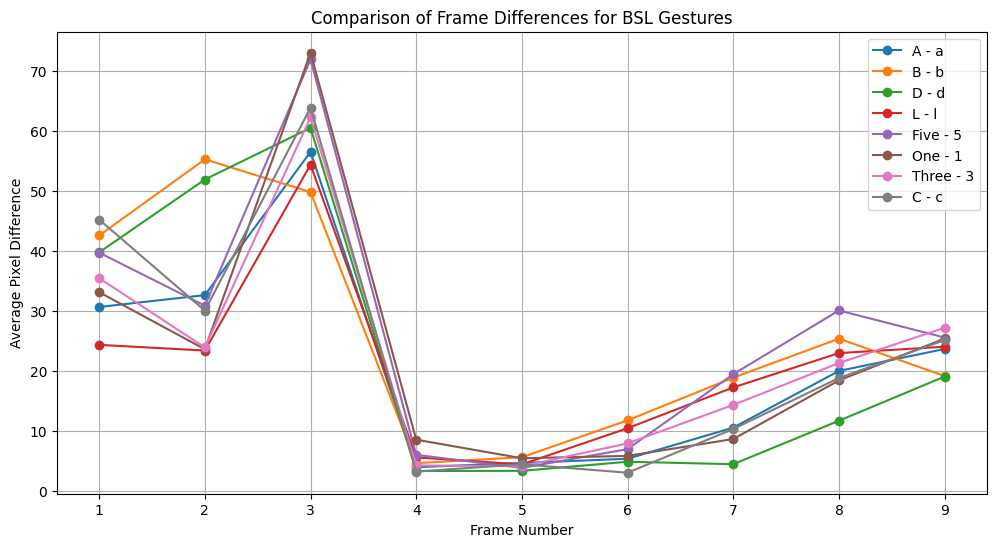

Class: A - a
Mean Difference: 20.83
Max Difference: 56.45
Min Difference: 3.90
----------------------------------------
Class: B - b
Mean Difference: 25.84
Max Difference: 55.21
Min Difference: 4.56
----------------------------------------
Class: D - d
Mean Difference: 22.05
Max Difference: 60.46
Min Difference: 3.26
----------------------------------------
Class: L - l
Mean Difference: 20.70
Max Difference: 54.32
Min Difference: 4.36
----------------------------------------
Class: Five - 5
Mean Difference: 25.99
Max Difference: 71.88
Min Difference: 3.78
----------------------------------------
Class: One - 1
Mean Difference: 22.40
Max Difference: 72.98
Min Difference: 5.39
----------------------------------------
Class: Three - 3
Mean Difference: 22.25
Max Difference: 62.20
Min Difference: 4.06
----------------------------------------
Class: C - c
Mean Difference: 22.63
Max Difference: 63.82
Min Difference: 2.98
----------------------------------------


In [ ]:
# Extended classes to compare (from both datasets)
selected_classes = {
    "A - a": "2-Hand",
    "B - b": "2-Hand",
    "D - d": "2-Hand",
    "L - l": "2-Hand",
    "Five - 5": "1-Hand",
    "One - 1": "1-Hand",
    "Three - 3": "1-Hand",
    "C - c": "1-Hand"
}

# Function to compute average pixel differences between frames
def compute_frame_differences(class_name, dataset_type):
    class_path = os.path.join(dataset_paths[dataset_type], class_name)

    if not os.path.exists(class_path):
        print(f"Class '{class_name}' not found in {dataset_type} dataset!")
        return None

    # Getting sorted list of image files
    image_files = sorted([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) < 2:
        print(f"Not enough images for class '{class_name}' in {dataset_type} dataset!")
        return None

    # Loading images
    images = []
    for img_file in image_files[:10]:  # Limit to first 10 frames
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        images.append(img)

    images = np.array(images)

    # Computing pixel differences
    differences = []
    for i in range(len(images) - 1):
        diff = np.abs(images[i].astype(np.float32) - images[i + 1].astype(np.float32))
        differences.append(np.mean(diff))

    return differences

# Storing results for all classes
class_differences = {}
for class_name, dataset_type in selected_classes.items():
    differences = compute_frame_differences(class_name, dataset_type)
    if differences:
        class_differences[class_name] = differences

# Plotting results
plt.figure(figsize=(12, 6))
for class_name, differences in class_differences.items():
    plt.plot(range(1, len(differences) + 1), differences, marker='o', linestyle='-', label=class_name)

plt.xlabel("Frame Number")
plt.ylabel("Average Pixel Difference")
plt.title("Comparison of Frame Differences for BSL Gestures")
plt.legend()
plt.grid()
plt.show()

# Displaying statistics for each class
for class_name, differences in class_differences.items():
    print(f"Class: {class_name}")
    print(f"Mean Difference: {np.mean(differences):.2f}")
    print(f"Max Difference: {np.max(differences):.2f}")
    print(f"Min Difference: {np.min(differences):.2f}")
    print("-" * 40)

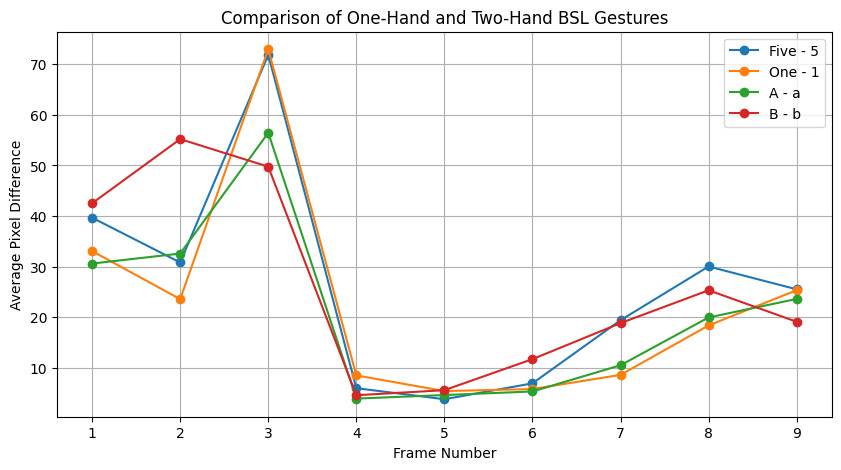

Class: Five - 5
Mean Difference: 25.99
Max Difference: 71.88
Min Difference: 3.78
----------------------------------------
Class: One - 1
Mean Difference: 22.40
Max Difference: 72.98
Min Difference: 5.39
----------------------------------------
Class: A - a
Mean Difference: 20.83
Max Difference: 56.45
Min Difference: 3.90
----------------------------------------
Class: B - b
Mean Difference: 25.84
Max Difference: 55.21
Min Difference: 4.56
----------------------------------------


In [ ]:
# Chosing classes to compare (from both datasets)
selected_classes = {
    "Five - 5": "1-Hand",  # One hand
    "One - 1": "1-Hand",
    "A - a": "2-Hand",  # Both hands
    "B - b": "2-Hand"
}

# Function to compute average pixel differences between frames
def compute_frame_differences(class_name, dataset_type):
    class_path = os.path.join(dataset_paths[dataset_type], class_name)

    if not os.path.exists(class_path):
        print(f"Class '{class_name}' not found in {dataset_type} dataset!")
        return None

    # Getting sorted list of image files
    image_files = sorted([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) < 2:
        print(f"Not enough images for class '{class_name}' in {dataset_type} dataset!")
        return None

    # Loading images
    images = []
    for img_file in image_files[:10]:  # Limit to first 10 frames
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        images.append(img)

    images = np.array(images)

    # Computing pixel differences
    differences = []
    for i in range(len(images) - 1):
        diff = np.abs(images[i].astype(np.float32) - images[i + 1].astype(np.float32))
        differences.append(np.mean(diff))

    return differences

# Storing results for all classes
class_differences = {}
for class_name, dataset_type in selected_classes.items():
    differences = compute_frame_differences(class_name, dataset_type)
    if differences:
        class_differences[class_name] = differences

# Plotting results
plt.figure(figsize=(10, 5))
for class_name, differences in class_differences.items():
    plt.plot(range(1, len(differences) + 1), differences, marker='o', linestyle='-', label=class_name)

plt.xlabel("Frame Number")
plt.ylabel("Average Pixel Difference")
plt.title("Comparison of One-Hand and Two-Hand BSL Gestures")
plt.legend()
plt.grid()
plt.show()

# Displaying statistics
for class_name, differences in class_differences.items():
    print(f"Class: {class_name}")
    print(f"Mean Difference: {np.mean(differences):.2f}")
    print(f"Max Difference: {np.max(differences):.2f}")
    print(f"Min Difference: {np.min(differences):.2f}")
    print("-" * 40)

# Installing Mediapipe for Hand points Extraction

In [ ]:
!pip install mediapipe

# Applying Mediapipe to samples form dataset

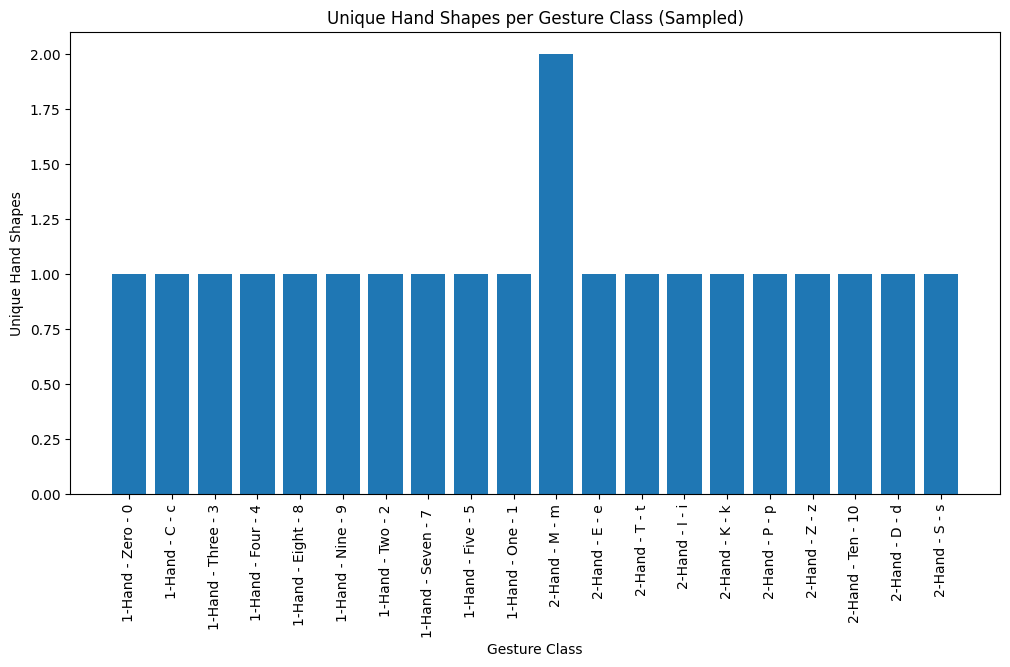

In [ ]:
import mediapipe as mp

# Initialise MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

class_counts = {}

# Limit the number of classes to speed up analysis (select 10 random classes)
selected_classes = {}
for dataset_type, dataset_path in dataset_paths.items():
    all_classes = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]
    selected_classes[dataset_type] = np.random.choice(all_classes, min(10, len(all_classes)), replace=False)

# Processing selected classes only
for dataset_type, class_list in selected_classes.items():
    for class_name in class_list:
        class_path = os.path.join(dataset_paths[dataset_type], class_name)
        if not os.path.isdir(class_path):
            continue

        # Selecting up to 10 images per class
        image_files = sorted([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])[:10]

        hand_shapes = set()

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = hands.process(image_rgb)

            if results.multi_hand_landmarks:
                hand_shapes.add(len(results.multi_hand_landmarks))

        class_counts[f"{dataset_type} - {class_name}"] = len(hand_shapes)

# Plotting unique hand shapes per gesture class
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Gesture Class")
plt.ylabel("Unique Hand Shapes")
plt.xticks(rotation=90)
plt.title("Unique Hand Shapes per Gesture Class (Sampled)")
plt.show()

# Checking Pixel value range

Pixel value range before rescaling: Min=0, Max=255


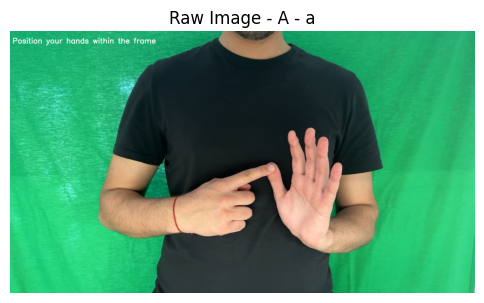

In [ ]:
# Defining random dataset paths
random_class = "A - a"
dataset_path = "/content/drive/MyDrive/BSL_Dataset/2_HAND_DATASET/2_HAND_DATASET"
class_path = os.path.join(dataset_path, random_class)

# Extracting random image
image_files = sorted([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
if not image_files:
    print("No images found in the selected class!")
else:
    img_path = os.path.join(class_path, image_files[0])
    image = cv2.imread(img_path)

    # Checking Pixel value range
    min_val, max_val = image.min(), image.max()
    print(f"Pixel value range before rescaling: Min={min_val}, Max={max_val}")

    # Plotting
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Conversion from BGR → RGB
    plt.axis("off")
    plt.title(f"Raw Image - {random_class}")
    plt.show()

# Initialise MediaPipe Hands

In [ ]:
# Initialise MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

# Defining save paths
save_dir = "/content/drive/MyDrive/BSL_Preprocessed"
os.makedirs(save_dir, exist_ok=True)
X_save_path = os.path.join(save_dir, "X_bsl.npy")
y_save_path = os.path.join(save_dir, "y_bsl.npy")
class_mapping_path = os.path.join(save_dir, "class_mapping.npy")

# Function to extract keypoints from an image
def extract_keypoints(image_path):
    """Extracts 21 keypoints (x, y, z) from a hand image using MediaPipe."""
    image = cv2.imread(image_path)
    if image is None:
        return np.zeros(21 * 3)  # If the image cannot be loaded, return a zero array

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting image to RGB
    results = hands.process(image_rgb)  # Processing the image with MediaPipe

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]  # Getting the first detected hand
        return np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
    else:
        return np.zeros(21 * 3)  # If no hand is detected, return a zero array

# Testing on a small sample before full processing
test_sequences, test_labels = [], []
test_classes = 3  # Number of classes to test
test_sequences_per_class = 3  # Number of sequences per class

print("Running test on a small sample...")

for dataset_type, dataset_path in dataset_paths.items():
    class_names = sorted(os.listdir(dataset_path))[:test_classes]  # Select limited classes

    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = sorted([
            os.path.join(class_path, f) for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])[:test_sequences_per_class * 30]  # Only pick a few images

        if len(image_files) < 30:
            print(f"Skipping {class_name} (not enough images)")
            continue

        for i in range(0, len(image_files) - 30, 30):
            sequence = [extract_keypoints(image_files[j]) for j in range(i, i + 30)]
            test_sequences.append(sequence)
            test_labels.append(class_name)

# Converting to NumPy arrays
X_test_sample = np.array(test_sequences)
y_test_sample = np.array(test_labels)

# Checking test sample shape and content
print(f"Test sample shape: {X_test_sample.shape}")
print(f"First 3 labels: {y_test_sample[:3]}")
print(f"Sample keypoints (first entry): \n{X_test_sample[0]}")

# If test passes, proceed with full dataset processing
input("Press Enter to start full dataset processing or Ctrl+C to stop.")

# Full Dataset Processing
sequences, labels = [], []
class_mapping = {}
class_index = 0
seq_length = 30  # Number of frames per sequence

for dataset_type, dataset_path in dataset_paths.items():
    for class_name in sorted(os.listdir(dataset_path)):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        if class_name not in class_mapping:
            class_mapping[class_name] = class_index
            class_index += 1

        image_files = sorted([
            os.path.join(class_path, f) for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

        if len(image_files) < seq_length:
            print(f"Skipping {class_name} (not enough images)")
            continue

        for frame_start in range(0, len(image_files) - seq_length, seq_length):
            sequence = [extract_keypoints(image_files[frame]) for frame in range(frame_start, frame_start + seq_length)]
            sequences.append(sequence)
            labels.append(class_mapping[class_name])

            if len(sequences) % 100 == 0:  # Save progress every 100 sequences
                np.save(X_save_path, np.array(sequences))
                np.save(y_save_path, np.array(labels))
                np.save(class_mapping_path, class_mapping)
                print(f"Saved {len(sequences)} sequences to disk...")

# Converting lists to NumPy arrays
X = np.array(sequences)
y = np.array(labels)

# Final save
np.save(X_save_path, X)
np.save(y_save_path, y)
np.save(class_mapping_path, class_mapping)

print(f"Final dataset saved at: {save_dir}")
print(f"Dataset shape: {X.shape}")  # To remember, Model will needs shape: (num_samples, 30, 63)
print(f"Labels shape: {y.shape}")   # Expected: (num_samples,)")

Running test on a small sample...
Test sample shape: (12, 30, 63)
First 3 labels: ['C - c' 'C - c' 'Eight - 8']
Sample keypoints (first entry): 
[[ 3.44132304e-01  7.37474501e-01  3.50859636e-07 ...  3.94523799e-01
   6.14567995e-01 -6.19158000e-02]
 [ 1.40212789e-01  7.07126200e-01  3.47287710e-07 ...  1.42246664e-01
   5.65803885e-01 -6.41266480e-02]
 [ 1.02834269e-01  7.30741262e-01  2.93070741e-07 ...  8.05922300e-02
   5.87249100e-01 -9.69526321e-02]
 ...
 [ 7.01458335e-01  8.17411423e-01  2.12846160e-07 ...  7.39311993e-01
   8.14915657e-01 -2.81015392e-02]
 [ 6.04944468e-01  8.27699780e-01  2.42985607e-07 ...  6.42489552e-01
   8.25134277e-01 -3.09855044e-02]
 [ 5.02712548e-01  8.07641029e-01  1.72574204e-07 ...  5.34872532e-01
   8.02317917e-01 -3.29481550e-02]]
Saved 100 sequences to disk...
Saved 200 sequences to disk...
Saved 300 sequences to disk...
Saved 400 sequences to disk...
Saved 500 sequences to disk...
Saved 600 sequences to disk...
Saved 700 sequences to disk...
Sa

# Checking if all sequences have the correct length (30 frames)

In [ ]:
# Checking the number of images in each class
for dataset_name, dataset_path in dataset_paths.items():
    print(f"\nChecking dataset: {dataset_name}")
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):
            image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"Class: {class_name}, Images: {image_count}")

# Checking if all sequences have the correct length (30 frames)
sequence_lengths = [len(seq) for seq in X]

print(f"Min sequence length: {min(sequence_lengths)}")
print(f"Max sequence length: {max(sequence_lengths)}")


Checking dataset: 1-Hand
Class: C - c, Images: 1000
Class: Eight - 8, Images: 1000
Class: Five - 5, Images: 1000
Class: Four - 4, Images: 1000
Class: Nine - 9, Images: 1000
Class: One - 1, Images: 1000
Class: Seven - 7 , Images: 1000
Class: Six - 6, Images: 1000
Class: Three - 3, Images: 1000
Class: Two - 2, Images: 1000
Class: Zero - 0, Images: 1000

Checking dataset: 2-Hand
Class: A - a, Images: 1000
Class: B - b, Images: 1000
Class: D - d, Images: 1000
Class: E - e, Images: 1000
Class: F - f, Images: 1000
Class: G - g, Images: 1000
Class: I - i, Images: 1000
Class: K - k, Images: 1000
Class: L - l, Images: 1000
Class: M - m, Images: 1000
Class: N - n, Images: 1000
Class: O - o, Images: 1000
Class: P - p, Images: 1000
Class: Q - q, Images: 1000
Class: R - r, Images: 1000
Class: S - s, Images: 1000
Class: T - t, Images: 1000
Class: Ten - 10, Images: 1000
Class: U - u, Images: 1000
Class: V - v, Images: 1000
Class: W - w, Images: 1000
Class: X - x, Images: 1000
Class: Z - z, Images: 1

# Loading Saved sequences. Starting modelling from this point, skip 2 hours of  Mediapipe processing.

# Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 28.1 MB/s eta 0:00:00


# MODELING PREPARATION

# Loading Libraries

In [5]:
import os
import numpy as np
import random
import cv2
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import collections
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten
from google.colab import drive
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D

# Loading preprocessed dataset

In [6]:
# Loading preprocessed dataset
X_data = np.load("/content/drive/MyDrive/BSL_Preprocessed/X_bsl.npy")
y_data = np.load("/content/drive/MyDrive/BSL_Preprocessed/y_bsl.npy")

# Converting labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_data))
y_data = to_categorical(y_data, num_classes=num_classes)

# Spliting dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=np.argmax(y_data, axis=1)
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

print(f"Dataset loaded: {X_train.shape}, {X_val.shape}, {X_test.shape}")

Dataset loaded: (897, 30, 63), (112, 30, 63), (113, 30, 63)


# Displaying Plots to check Hand Detection




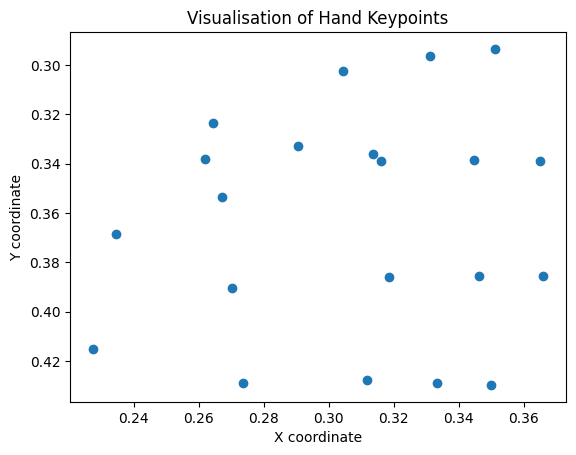

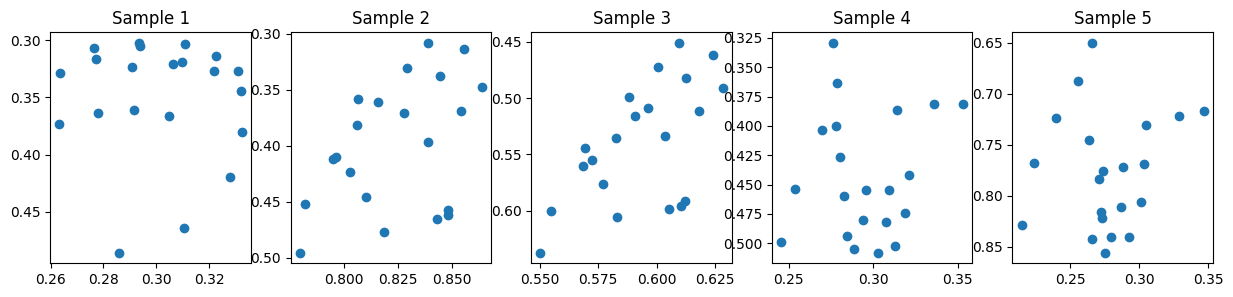

Detected hands in 1118/1122 samples


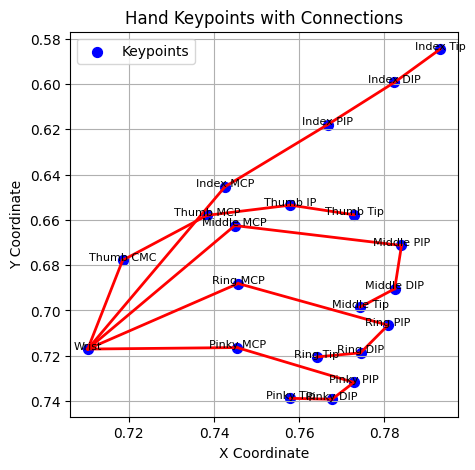

In [7]:
# Loading the training dataset
X_train = np.load("/content/drive/MyDrive/BSL_Preprocessed/X_bsl.npy")

# Function to visualise a single hand keypoints sample
def plot_single_hand_keypoints(sample_sequence, title="Visualisation of Hand Keypoints"):
    keypoints = sample_sequence[0].reshape(21, 3)  # Extract first frame
    x, y, z = keypoints[:, 0], keypoints[:, 1], keypoints[:, 2]

    plt.scatter(x, y)
    plt.gca().invert_yaxis()  # Invert Y-axis for correct orientation
    plt.title(title)
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.show()

# Displaying a random hand keypoints sample
sample_index = random.randint(0, len(X_train) - 1)
plot_single_hand_keypoints(X_train[sample_index])

# Function to visualise multiple hand keypoints samples
def plot_multiple_hand_keypoints(samples=5):
    fig, axes = plt.subplots(1, samples, figsize=(15, 3))

    for i in range(samples):
        sample_index = random.randint(0, len(X_train) - 1)
        sample_sequence = X_train[sample_index]

        keypoints = sample_sequence[0].reshape(21, 3)  # Extract first frame
        x, y, z = keypoints[:, 0], keypoints[:, 1], keypoints[:, 2]

        axes[i].scatter(x, y)
        axes[i].invert_yaxis()
        axes[i].set_title(f"Sample {i+1}")

    plt.show()

# Displaying multiple random hand keypoints samples
plot_multiple_hand_keypoints()

# Counting detected hands in dataset
hand_detected_count = sum(not np.all(sample[0] == 0) for sample in X_train)
print(f"Detected hands in {hand_detected_count}/{len(X_train)} samples")

# Function to plot hand keypoints with bone connections
def plot_hand_with_connections(keypoints):
    """
    Ploting hand keypoints with labeled connections.

    """
    connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),   # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),   # Index finger
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
        (0, 17), (17, 18), (18, 19), (19, 20)   # Pinky
    ]

    part_labels = [
        "Wrist", "Thumb CMC", "Thumb MCP", "Thumb IP", "Thumb Tip",
        "Index MCP", "Index PIP", "Index DIP", "Index Tip",
        "Middle MCP", "Middle PIP", "Middle DIP", "Middle Tip",
        "Ring MCP", "Ring PIP", "Ring DIP", "Ring Tip",
        "Pinky MCP", "Pinky PIP", "Pinky DIP", "Pinky Tip"
    ]

    plt.figure(figsize=(5, 5))
    plt.scatter(keypoints[:, 0], keypoints[:, 1], color='blue', s=50, label="Keypoints")

    for start, end in connections:
        plt.plot([keypoints[start, 0], keypoints[end, 0]],
                 [keypoints[start, 1], keypoints[end, 1]], 'r-', linewidth=2)

    # Adding labels for each keypoint
    for i, (x, y, _) in enumerate(keypoints):
        plt.text(x, y, part_labels[i], fontsize=8, color="black", ha="center")

    plt.gca().invert_yaxis()  # Inverting Y-axis for image coordinate system
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Hand Keypoints with Connections")
    plt.legend()
    plt.grid(True)
    plt.show()


# Extracting and display hand keypoints with labels
sample_index = random.randint(0, len(X_train) - 1)
keypoints = X_train[sample_index][0].reshape(21, 3)
plot_hand_with_connections(keypoints)

In [8]:
# Checking amounts of hands detected in X_train
hand_detected_count = sum(not np.all(sample[0] == 0) for sample in X_train)
print(f"Detected hands in {hand_detected_count}/{len(X_train)} samples")

Detected hands in 1118/1122 samples


In [9]:
# Checking Sample
sample_index = random.randint(0, len(X_train) - 1)
keypoints = X_train[sample_index][0].reshape(21, 3)
print(keypoints)

[[ 5.50233245e-01  7.01298475e-01  8.86409879e-08]
 [ 5.78061223e-01  6.63863420e-01  5.57225058e-03]
 [ 5.89425445e-01  6.25136375e-01  4.25979914e-03]
 [ 6.00483000e-01  5.99955082e-01 -5.80303953e-04]
 [ 6.09176099e-01  5.77552974e-01 -4.75078635e-03]
 [ 5.48107684e-01  5.81902444e-01  4.57834918e-03]
 [ 5.74283957e-01  5.37567496e-01 -5.10346843e-03]
 [ 5.96481383e-01  5.40916264e-01 -1.27452472e-02]
 [ 6.10161066e-01  5.53892195e-01 -1.66028347e-02]
 [ 5.45479238e-01  5.85538387e-01 -3.81742604e-03]
 [ 5.74766219e-01  5.30625463e-01 -1.28261568e-02]
 [ 5.98618627e-01  5.37177384e-01 -1.79177560e-02]
 [ 6.11220837e-01  5.55148840e-01 -1.96747296e-02]
 [ 5.50503612e-01  5.95280707e-01 -1.25854434e-02]
 [ 5.76883793e-01  5.41185558e-01 -1.95985511e-02]
 [ 6.00415111e-01  5.44809878e-01 -2.03948449e-02]
 [ 6.12453222e-01  5.60779214e-01 -1.91585552e-02]
 [ 5.61972916e-01  6.10545158e-01 -2.12668441e-02]
 [ 5.83791316e-01  5.68384349e-01 -2.51668319e-02]
 [ 6.00953579e-01  5.63924670e-

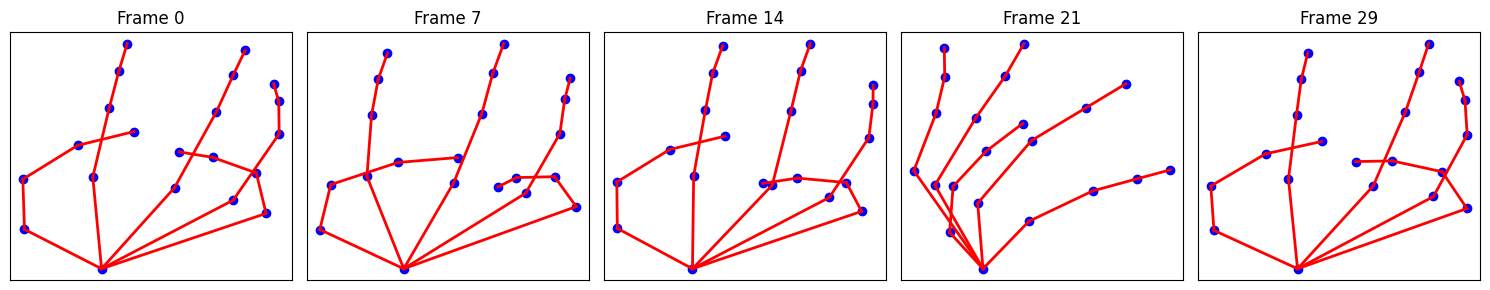

In [10]:
# Plotting multiple frames of a hand keypoint sequence
def plot_hand_sequence(sample_sequence, num_frames=5):

    # Ensuring correct shape
    if sample_sequence.shape[-1] != 3:
        raise ValueError(f"Expected shape (30, 21, 3), but got {sample_sequence.shape}")

    connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),   # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),   # Index finger
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
        (0, 17), (17, 18), (18, 19), (19, 20)   # Pinky
    ]

    fig, axes = plt.subplots(1, num_frames, figsize=(15, 3))

    frame_indices = np.linspace(0, sample_sequence.shape[0] - 1, num_frames, dtype=int)

    for i, frame_idx in enumerate(frame_indices):
        keypoints = sample_sequence[frame_idx]  # Select frame
        x, y = keypoints[:, 0], keypoints[:, 1]

        axes[i].scatter(x, y, color='blue', label="Keypoints")
        axes[i].invert_yaxis()  # Invert Y-axis

        # Drawing connections
        for start, end in connections:
            axes[i].plot([x[start], x[end]], [y[start], y[end]], 'r-', linewidth=2)

        axes[i].set_title(f"Frame {frame_idx}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

# Select a random sample from X_train
sample_index = np.random.randint(0, len(X_train))
sample_sequence = X_train[sample_index]

# Reshape if needed
if sample_sequence.shape[-1] != 3:
    sample_sequence = sample_sequence.reshape(30, 21, 3)

# Plotting hand movement over time
plot_hand_sequence(sample_sequence, num_frames=5)

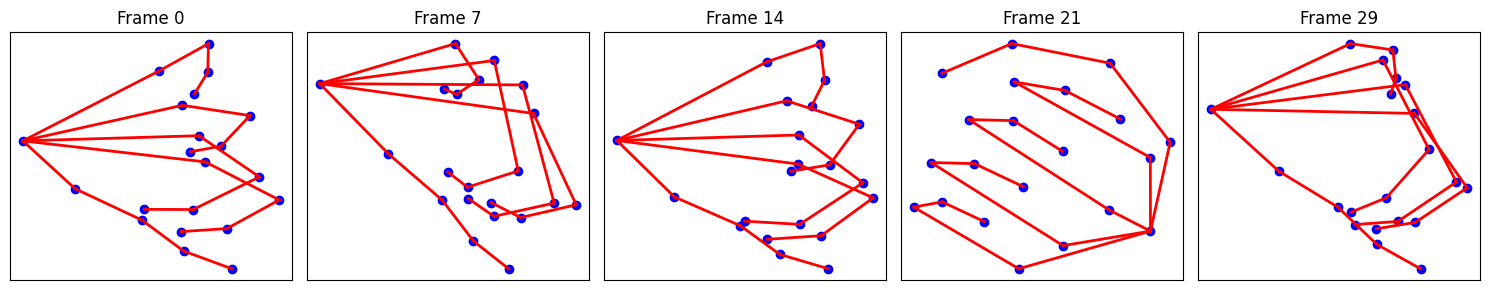

In [11]:
# Plotting multiple frames of a hand keypoint sequence in order.
def plot_hand_sequence(sample_sequence, num_frames=5):

    connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),   # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),   # Index finger
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
        (0, 17), (17, 18), (18, 19), (19, 20)   # Pinky
    ]

    fig, axes = plt.subplots(1, num_frames, figsize=(15, 3))

    frame_indices = np.linspace(0, sample_sequence.shape[0] - 1, num_frames, dtype=int)

    for i, frame_idx in enumerate(frame_indices):
        keypoints = sample_sequence[frame_idx]  # Select frame
        x, y = keypoints[:, 0], keypoints[:, 1]

        axes[i].scatter(x, y, color='blue', label="Keypoints")
        axes[i].invert_yaxis()  # Invert Y-axis

        # Drawing connections
        for start, end in connections:
            axes[i].plot([x[start], x[end]], [y[start], y[end]], 'r-', linewidth=2)

        axes[i].set_title(f"Frame {frame_idx}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

# Select a random sample from one class
class_index = 0
samples_from_class = np.where(np.argmax(y_train, axis=1) == class_index)[0]

if len(samples_from_class) == 0:
    print(f"No samples found for class {class_index}")
else:
    sample_index = np.random.choice(samples_from_class)
    sample_sequence = X_train[sample_index]

    # Reshape if needed
    if sample_sequence.shape[-1] != 3:
        sample_sequence = sample_sequence.reshape(30, 21, 3)

    # Ploting hand movement over time
    plot_hand_sequence(sample_sequence, num_frames=5)

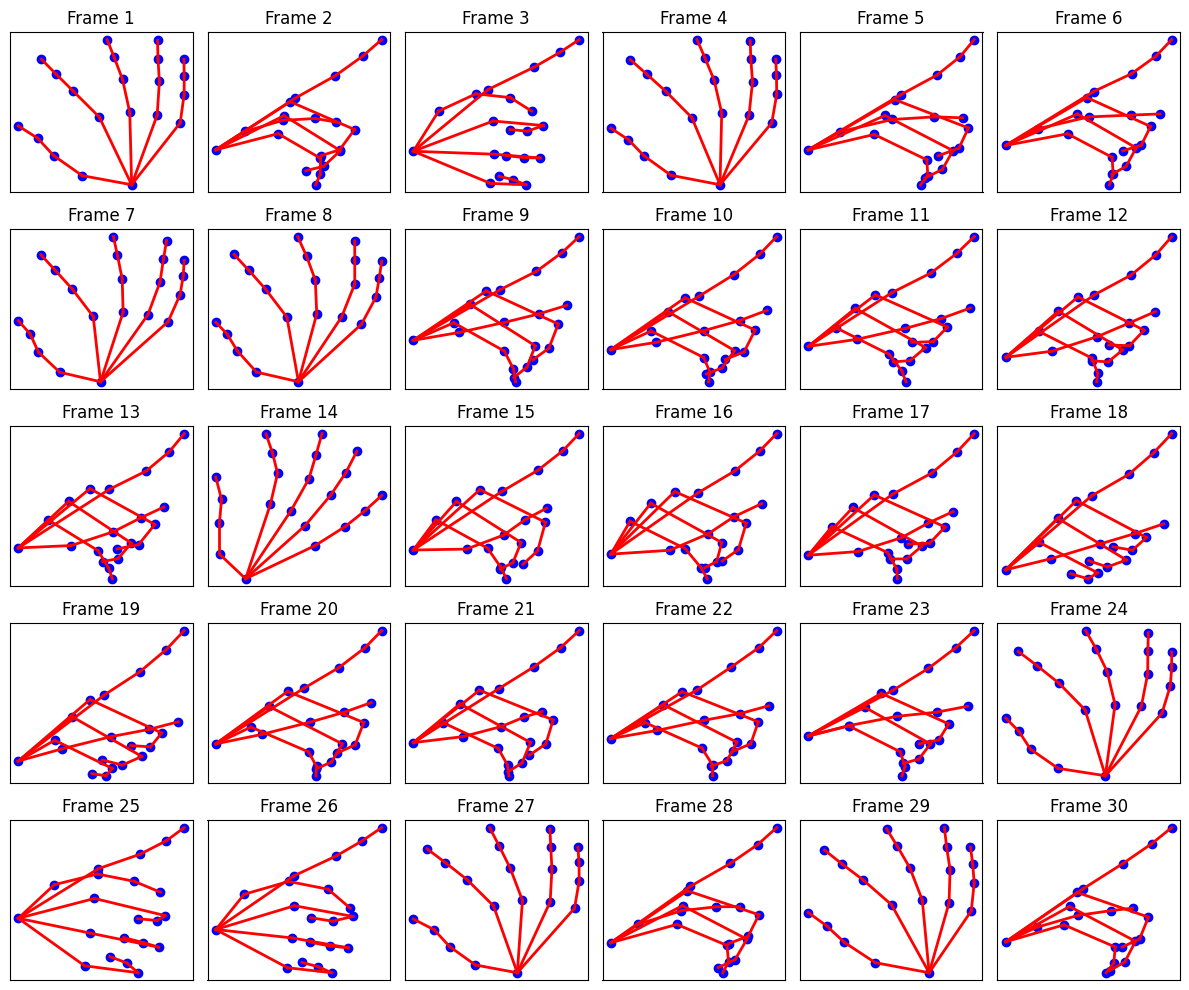

In [12]:
# Plots all frames of a hand keypoint sequence in order.
def plot_full_sequence(sample_sequence):
    connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),   # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),   # Index finger
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
        (0, 17), (17, 18), (18, 19), (19, 20)   # Pinky
    ]

    fig, axes = plt.subplots(5, 6, figsize=(12, 10))  # 5 rows, 6 columns
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for frame_idx in range(30):  # Iterate through all 30 frames
        keypoints = sample_sequence[frame_idx]  # Selecting frame
        x, y = keypoints[:, 0], keypoints[:, 1]

        axes[frame_idx].scatter(x, y, color='blue', label="Keypoints")
        axes[frame_idx].invert_yaxis()  # Invert Y-axis

        # Drawing connections
        for start, end in connections:
            axes[frame_idx].plot([x[start], x[end]], [y[start], y[end]], 'r-', linewidth=2)

        axes[frame_idx].set_title(f"Frame {frame_idx + 1}")
        axes[frame_idx].set_xticks([])
        axes[frame_idx].set_yticks([])

    plt.tight_layout()
    plt.show()

# Select a random sample from one class
class_index = 7
samples_from_class = np.where(np.argmax(y_train, axis=1) == class_index)[0]

if len(samples_from_class) == 0:
    print(f"No samples found for class {class_index}")
else:
    sample_index = np.random.choice(samples_from_class)
    sample_sequence = X_train[sample_index]

    # Reshape if needed
    if sample_sequence.shape[-1] != 3:
        sample_sequence = sample_sequence.reshape(30, 21, 3)

    # Plotting full hand movement sequence
    plot_full_sequence(sample_sequence)

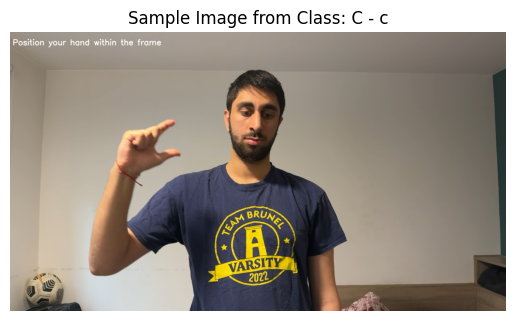

Hand detected in: /content/drive/MyDrive/BSL_Dataset/1_HAND_DATASET/1_HAND_DATASET/C - c/4370.png


In [13]:
# Defining dataset paths for both 1-hand and 2-hand gestures
dataset_paths = {
    "1-Hand": "/content/drive/MyDrive/BSL_Dataset/1_HAND_DATASET/1_HAND_DATASET",
    "2-Hand": "/content/drive/MyDrive/BSL_Dataset/2_HAND_DATASET/2_HAND_DATASET",
}

# Initialise MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

# Displaying a random image from the dataset
test_img_path = list(dataset_paths.values())[0]  # First root
first_class = os.listdir(test_img_path)[0]
first_image_path = os.path.join(test_img_path, first_class, os.listdir(os.path.join(test_img_path, first_class))[0])

img = cv2.imread(first_image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Sample Image from Class: {first_class}")
plt.show()

# Checking if MediaPipe detects a hand in this image
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = hands.process(image_rgb)

if results.multi_hand_landmarks:
    print(f"Hand detected in: {first_image_path}")
else:
    print(f"No hand detected in: {first_image_path}")

# Reloading preprocessed dataset

In [14]:
# Loading preprocessed dataset
X_data = np.load("/content/drive/MyDrive/BSL_Preprocessed/X_bsl.npy")
y_data = np.load("/content/drive/MyDrive/BSL_Preprocessed/y_bsl.npy")

# Converting labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_data))
y_data = to_categorical(y_data, num_classes=num_classes)

# Spliting dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=np.argmax(y_data, axis=1)
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

print(f"Dataset loaded: {X_train.shape}, {X_val.shape}, {X_test.shape}")

Dataset loaded: (897, 30, 63), (112, 30, 63), (113, 30, 63)


# Defining Function to generate Confusion Matrix

In [15]:
# Function to plot and save confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Function to plot accuracy and loss

In [16]:
# Function to plot accuracy and loss
def plot_training_history(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Training vs Validation Accuracy - {model_name}')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training vs Validation Loss - {model_name}')
    plt.show()

# MODELING

# LSTM Model 1

In [17]:
# Defining Basic LSTM Model (LSTM Model 1)
model_lstm_1 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(30, 63)),  # 30 frames, 63 features per frame
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compiling the basic LSTM model
model_lstm_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - categorical_accuracy: 0.0282 - loss: 3.5518 - val_categorical_accuracy: 0.0179 - val_loss: 3.5277 - learning_rate: 0.0010
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.0204 - loss: 3.5391 - val_categorical_accuracy: 0.0089 - val_loss: 3.5319 - learning_rate: 0.0010
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.0258 - loss: 3.5416 - val_categorical_accuracy: 0.0268 - val_loss: 3.5193 - learning_rate: 0.0010
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.0235 - loss: 3.5306 - val_categorical_accuracy: 0.0357 - val_loss: 3.5132 - learning_rate: 0.0010
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.0458 - loss: 3.5082 - val_categorical_accuracy: 0.0357 - val_loss: 3.5366 - learning_rate: 0.0010
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.0357 - loss: 3.5173 - val_categorical_accu

LSTM Model 1 - Test Accuracy: 0.8053
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         4
           2       0.75      0.75      0.75         4
           3       0.75      0.75      0.75         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.67      0.50      0.57         4
           7       0.60      0.75      0.67         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      0.75      0.86         4
          12       1.00      1.00      1.00         3
          13       0.67      0.67      0.67         3
          14       1.00      0.25      0.40         4
          15       0.60      1.00      0.75         3
          16       1.00      1.00      1.00 

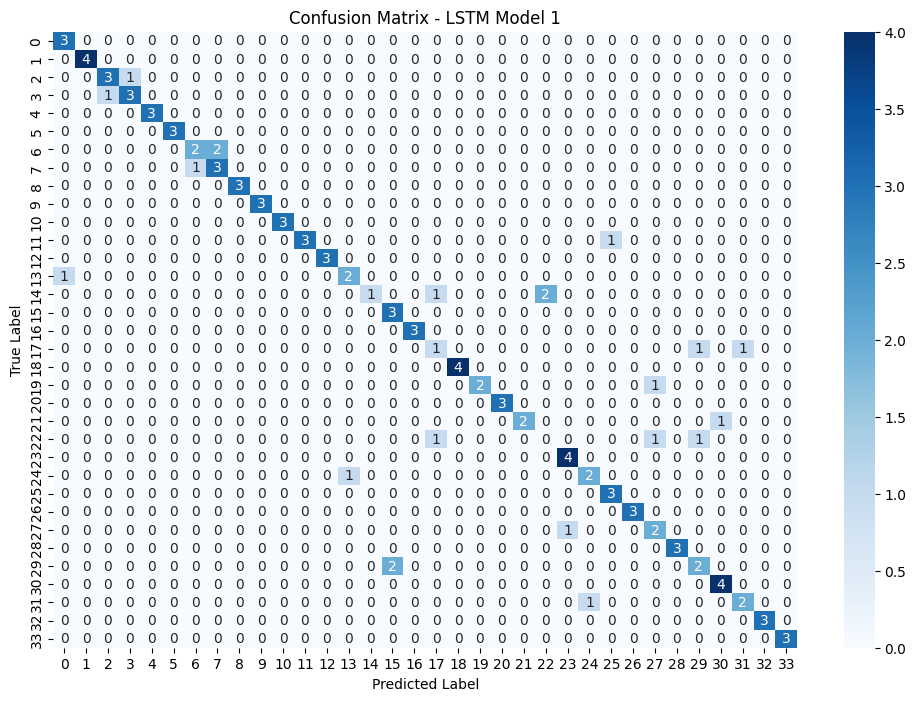

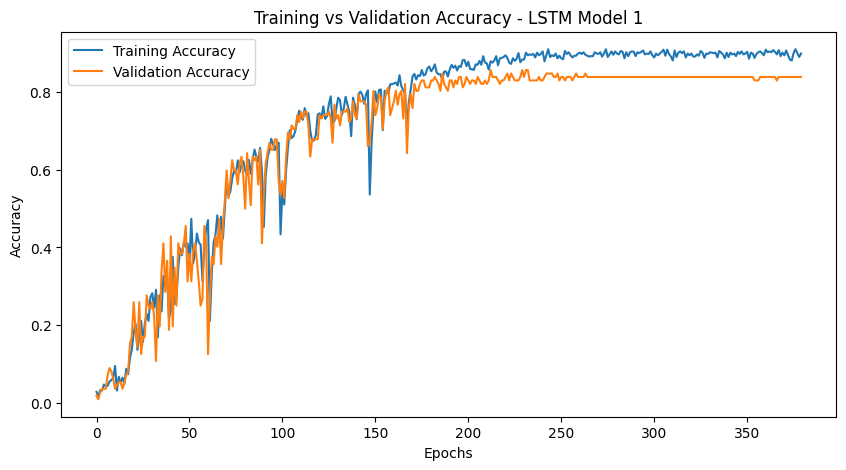

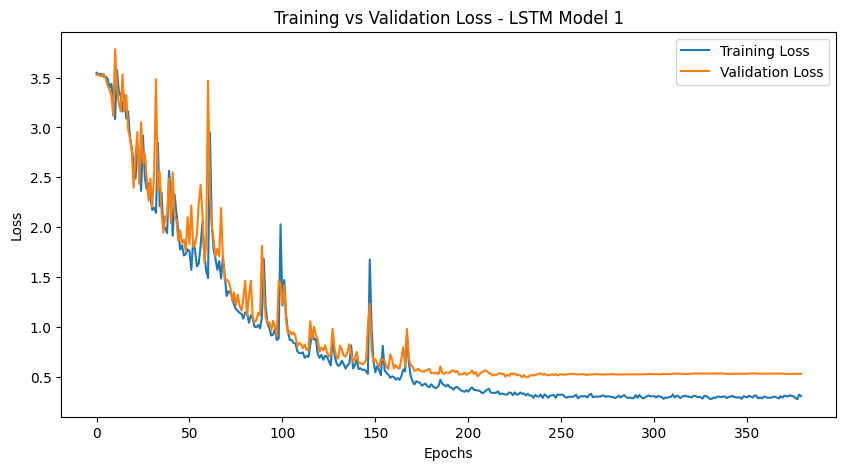

In [18]:
# Training LSTM Model 1
history_lstm_1 = model_lstm_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping, lr_reduction]
)

# Evaluating LSTM Model 1
y_pred_lstm_1 = model_lstm_1.predict(X_test)
y_pred_classes_lstm_1 = np.argmax(y_pred_lstm_1, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

test_accuracy_lstm_1 = accuracy_score(y_true_classes, y_pred_classes_lstm_1)
print(f"LSTM Model 1 - Test Accuracy: {test_accuracy_lstm_1:.4f}")
print(classification_report(y_true_classes, y_pred_classes_lstm_1))

# Saving LSTM Model 1
model_lstm_1.save("/content/drive/MyDrive/BSL_Preprocessed/bsl_model_lstm_1.h5")
print("LSTM Model 1 saved successfully!")

# Plotting confusion matrix for LSTM Model 1
plot_confusion_matrix(y_true_classes, y_pred_classes_lstm_1, "LSTM Model 1")
# Plotting accuracy and loss
plot_training_history(history_lstm_1, "LSTM Model 1")

# LSTM Model Advanced Deep

In [19]:
# Defining Advanced Deep LSTM Model (LSTM Model Advanced)
model_lstm_advanced = Sequential([
    Input(shape=(30, 63)),  # 30 frames, 63 features per frame

    Bidirectional(LSTM(256, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

# Compiling the advanced LSTM model
model_lstm_advanced.compile(optimizer=AdamW(learning_rate=1e-3),
                            loss='categorical_crossentropy',
                            metrics=['categorical_accuracy'])

Epoch 1/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - categorical_accuracy: 0.0330 - loss: 4.2601 - val_categorical_accuracy: 0.0089 - val_loss: 3.5621 - learning_rate: 0.0010
Epoch 2/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - categorical_accuracy: 0.0434 - loss: 4.0743 - val_categorical_accuracy: 0.0268 - val_loss: 3.5780 - learning_rate: 0.0010
Epoch 3/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - categorical_accuracy: 0.0361 - loss: 4.0615 - val_categorical_accuracy: 0.0357 - val_loss: 3.6252 - learning_rate: 0.0010
Epoch 4/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - categorical_accuracy: 0.0235 - loss: 4.0154 - val_categorical_accuracy: 0.0268 - val_loss: 3.6710 - learning_rate: 0.0010
Epoch 5/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - categorical_accuracy: 0.0338 - loss: 3.9427 - val_categorical_accuracy: 0.0179 - val_loss: 3.6889 - learning_rate: 0.0010
Epoch 6/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - categorical_accuracy: 0.0413 - loss: 3.8836 - val_categorical_acc

Advanced LSTM Model - Test Accuracy: 0.9381
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      0.75      0.86         4
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       0.67      0.50      0.57         4
          15       1.00      1.00      1.00         3
          16       1.00      1.00    

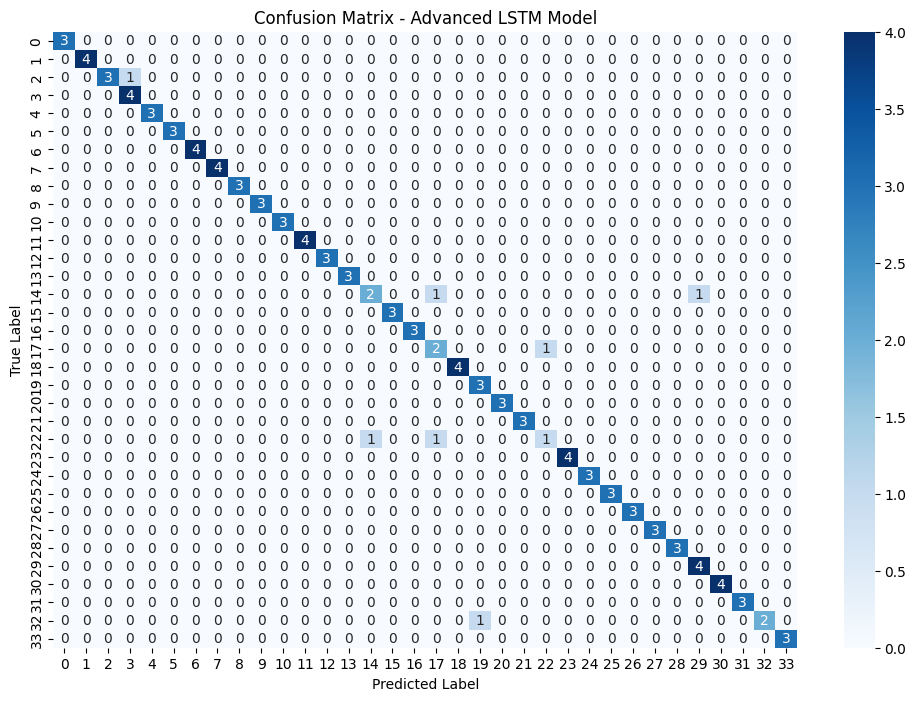

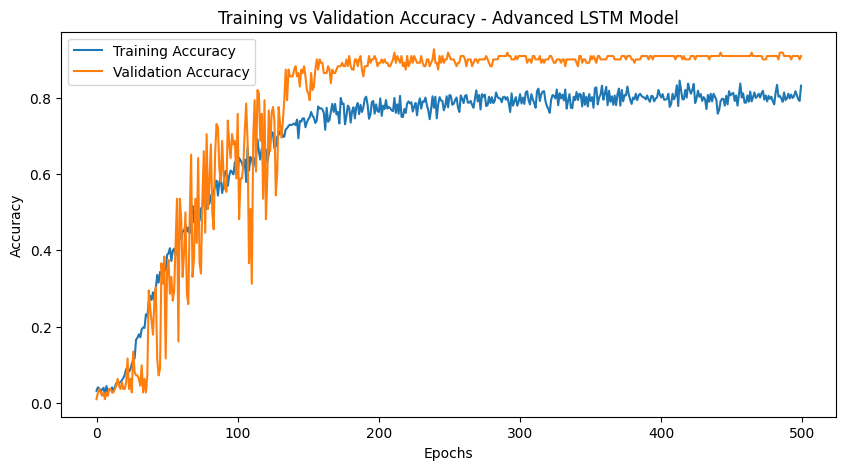

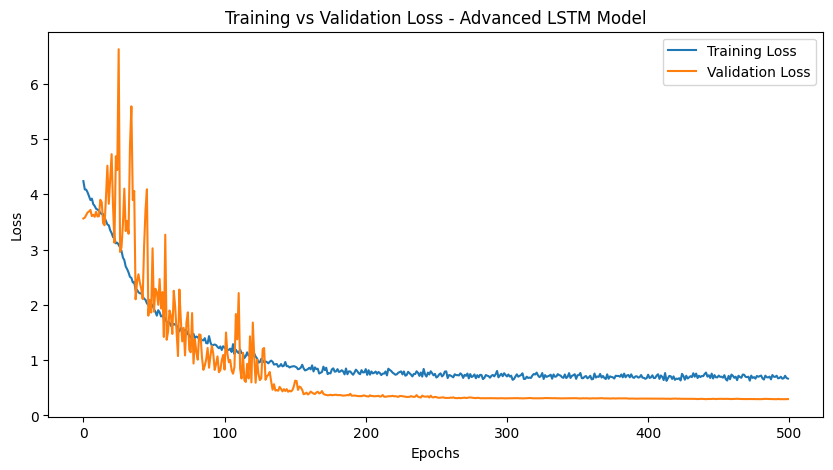

In [20]:
# Training Advanced LSTM Model
history_lstm_advanced = model_lstm_advanced.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[early_stopping, lr_reduction]
)

# Evaluating Advanced LSTM Model
y_pred_lstm_advanced = model_lstm_advanced.predict(X_test)
y_pred_classes_lstm_advanced = np.argmax(y_pred_lstm_advanced, axis=1)

test_accuracy_lstm_advanced = accuracy_score(y_true_classes, y_pred_classes_lstm_advanced)
print(f"Advanced LSTM Model - Test Accuracy: {test_accuracy_lstm_advanced:.4f}")
print(classification_report(y_true_classes, y_pred_classes_lstm_advanced))

# Saving Advanced LSTM Model
model_lstm_advanced.save("/content/drive/MyDrive/BSL_Preprocessed/bsl_lstm_advanced.h5")
print("Advanced LSTM Model saved successfully!")

# Ploting confusion matrix for Advanced LSTM Model
plot_confusion_matrix(y_true_classes, y_pred_classes_lstm_advanced, "Advanced LSTM Model")

# Plotting accuracy and loss
plot_training_history(history_lstm_advanced, "Advanced LSTM Model")

# Attention-based LSTM Model

Epoch 1/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - categorical_accuracy: 0.0347 - loss: 4.2269 - val_categorical_accuracy: 0.0089 - val_loss: 3.5662 - learning_rate: 0.0010
Epoch 2/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - categorical_accuracy: 0.0257 - loss: 4.2550 - val_categorical_accuracy: 0.0357 - val_loss: 3.5668 - learning_rate: 0.0010
Epoch 3/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - categorical_accuracy: 0.0380 - loss: 4.1830 - val_categorical_accuracy: 0.0268 - val_loss: 3.5972 - learning_rate: 0.0010
Epoch 4/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - categorical_accuracy: 0.0270 - loss: 4.1113 - val_categorical_accuracy: 0.0357 - val_loss: 3.6686 - learning_rate: 0.0010
Epoch 5/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - categorical_accuracy: 0.0255 - loss: 3.9760 - val_categorical_accuracy: 0.0179 - val_loss: 3.6067 - learning_rate: 0.0010
Epoch 6/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - categorical_accuracy: 0.0389 - loss: 3.8824 - val_categorical_acc

1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 888ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step


Test Accuracy: 0.9381
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       0.67      1.00      0.80         4
           3       1.00      0.50      0.67         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       0.75      1.00      0.86         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       0.67      1.00      0.80         4
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
     

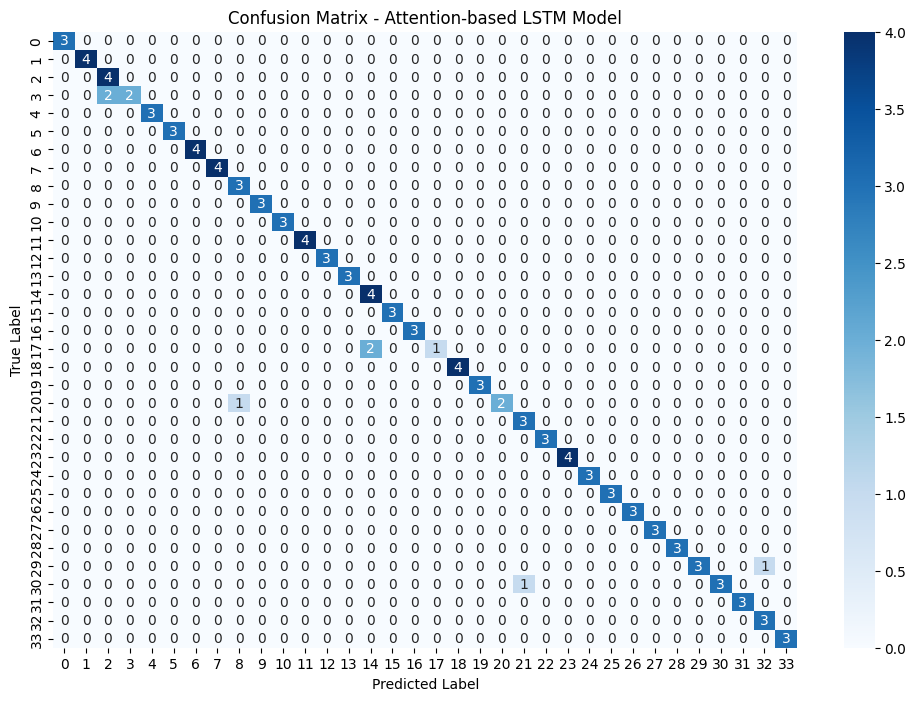

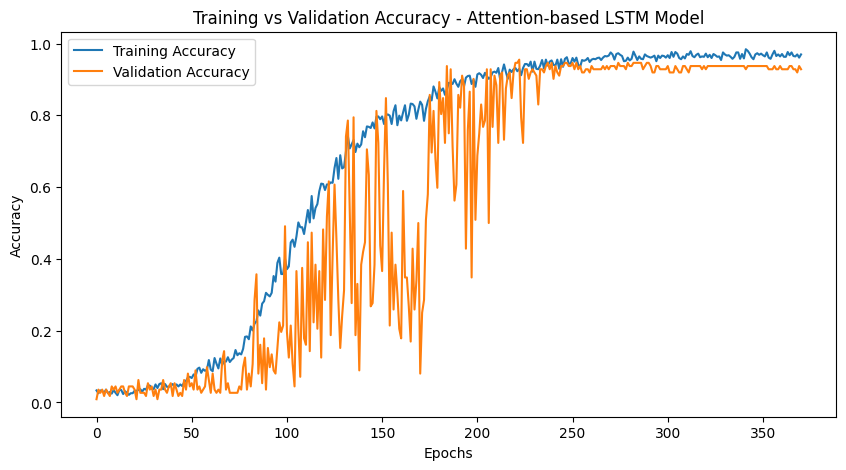

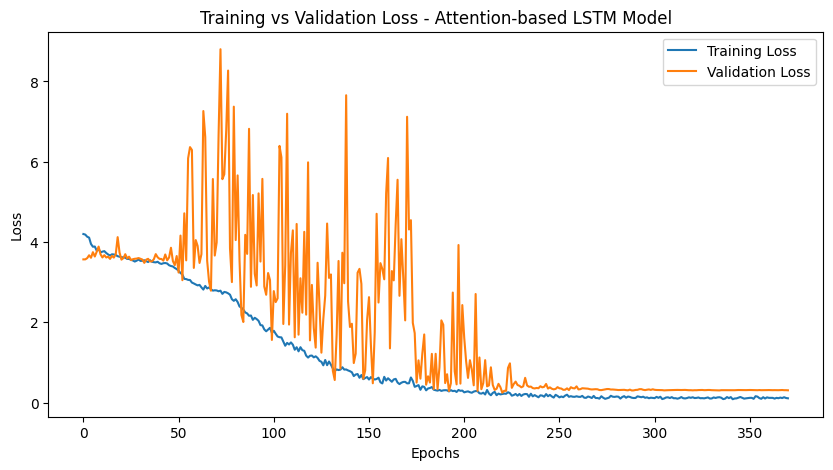

In [21]:
# Defineing input layer
inputs = Input(shape=(30, 63))

# First BiLSTM layer
x = Bidirectional(LSTM(256, return_sequences=True))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Self-Attention Layer
attention = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention = LayerNormalization()(attention)
x = tf.keras.layers.Add()([x, attention])  # Skip connection

# Additional BiLSTM layers
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Creating the model
model_lstm_attention = Model(inputs=inputs, outputs=outputs)

# Compiling the model
model_lstm_attention.compile(optimizer=AdamW(learning_rate=1e-3),
                            loss='categorical_crossentropy',
                            metrics=['categorical_accuracy'])

# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_lr=1e-6, verbose=1)

# Training the model
history_lstm_attention = model_lstm_attention.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[early_stopping, lr_reduction]
)

# Evaluating the model
y_pred_lstm_attention = model_lstm_attention.predict(X_test)
y_pred_classes_lstm_attention = np.argmax(y_pred_lstm_attention, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

test_accuracy_lstm_attention = accuracy_score(y_true_classes, y_pred_classes_lstm_attention)
print(f"Test Accuracy: {test_accuracy_lstm_attention:.4f}")
print(classification_report(y_true_classes, y_pred_classes_lstm_attention))

# Saving the model
model_lstm_attention.save("/content/drive/MyDrive/BSL_Preprocessed/bsl_lstm_attention.h5")
print("Model saved.")

# Ploting confusion matrix for Attention-based LSTM Model
plot_confusion_matrix(y_true_classes, y_pred_classes_lstm_attention, "Attention-based LSTM Model")
# Plotting accuracy and loss
plot_training_history(history_lstm_attention, "Attention-based LSTM Model")

# Updated Attention-based LSTM Model

Epoch 1/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - categorical_accuracy: 0.0278 - loss: 4.4185 - val_categorical_accuracy: 0.0089 - val_loss: 3.5389 - learning_rate: 0.0010
Epoch 2/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - categorical_accuracy: 0.0229 - loss: 4.1754 - val_categorical_accuracy: 0.0357 - val_loss: 3.6190 - learning_rate: 0.0010
Epoch 3/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - categorical_accuracy: 0.0332 - loss: 4.0596 - val_categorical_accuracy: 0.0268 - val_loss: 3.6106 - learning_rate: 0.0010
Epoch 4/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - categorical_accuracy: 0.0515 - loss: 3.8557 - val_categorical_accuracy: 0.0268 - val_loss: 3.6439 - learning_rate: 0.0010
Epoch 5/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - categorical_accuracy: 0.0393 - loss: 3.8964 - val_categorical_accuracy: 0.0536 - val_loss: 3.5808 - learning_rate: 0.0010
Epoch 6/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - categorical_accuracy: 0.0426 - loss: 3.8127 - val_categorical_acc

Updated Attention-based LSTM Model - Test Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         3
          16       1.0

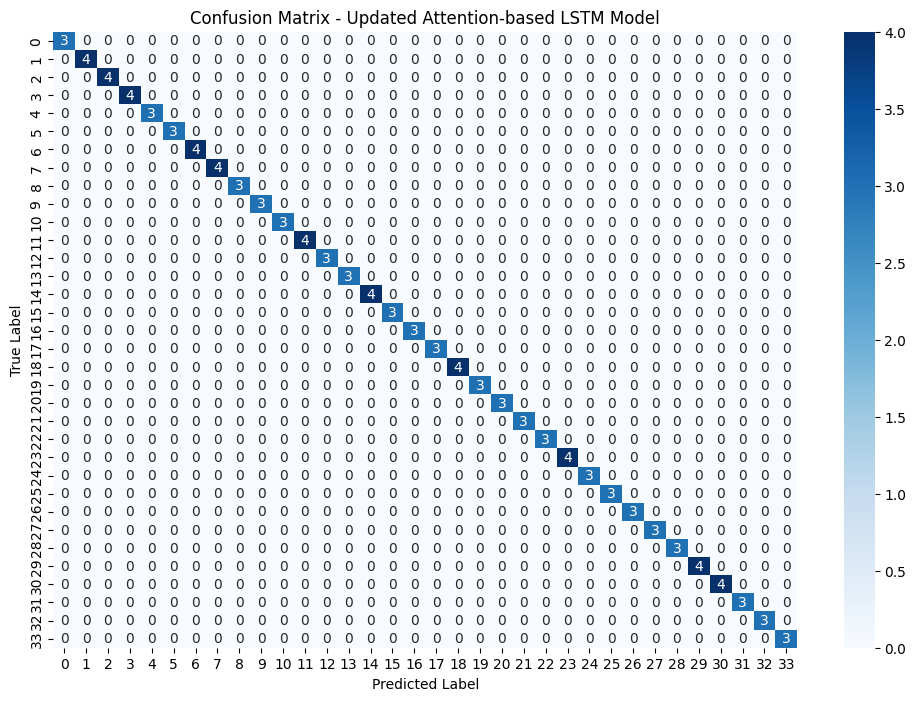

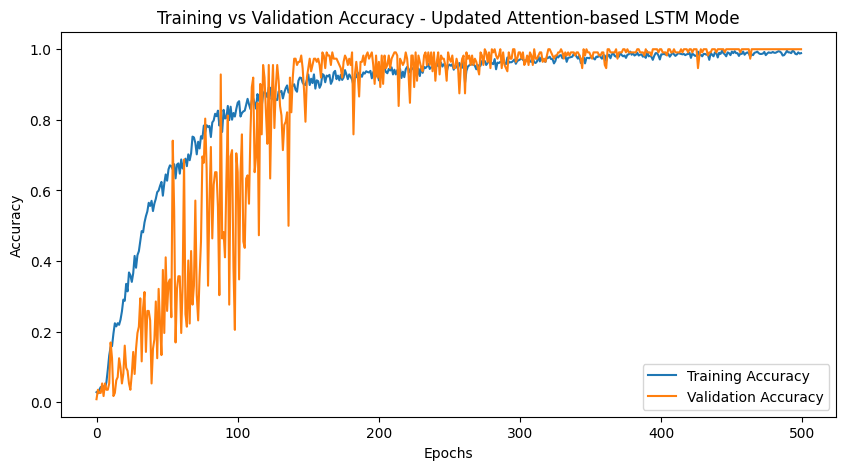

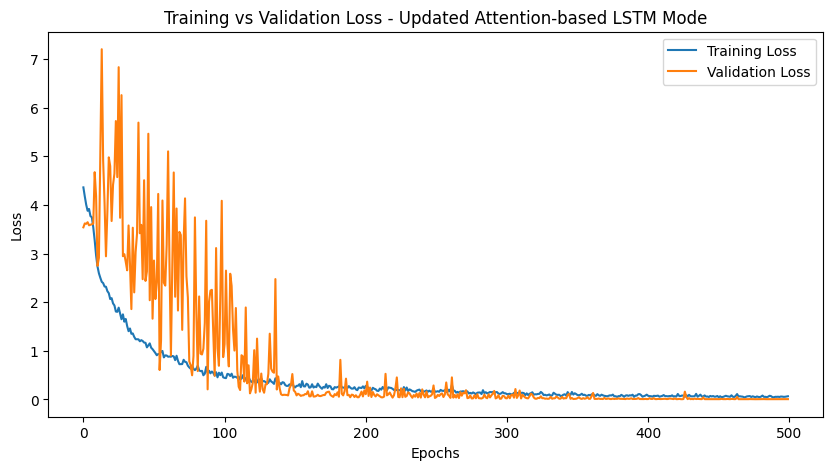

In [22]:
# Defining input layer
inputs = Input(shape=(30, 63))

# First Self-Attention Layer
attention_1 = MultiHeadAttention(num_heads=8, key_dim=64)(inputs, inputs)
attention_1 = LayerNormalization()(attention_1)
x = Add()([inputs, attention_1])  # Residual connection

# Second Self-Attention Layer
attention_2 = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
attention_2 = LayerNormalization()(attention_2)
x = Add()([x, attention_2])

# First BiLSTM layer
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second BiLSTM layer
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Third BiLSTM layer
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Creating the model
model_lstm_attention_v2 = Model(inputs=inputs, outputs=outputs)

# Compiling the model
model_lstm_attention_v2.compile(optimizer=AdamW(learning_rate=1e-3),
                            loss='categorical_crossentropy',
                            metrics=['categorical_accuracy'])

# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_lr=1e-6, verbose=1)

# Training the model
history_lstm_attention_v2 = model_lstm_attention_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[early_stopping, lr_reduction]
)

# Evaluating the model
y_pred_lstm_attention_v2 = model_lstm_attention_v2.predict(X_test)
y_pred_classes_lstm_attention_v2 = np.argmax(y_pred_lstm_attention_v2, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

test_accuracy_lstm_attention_v2 = accuracy_score(y_true_classes, y_pred_classes_lstm_attention_v2)
print(f"Updated Attention-based LSTM Model - Test Accuracy: {test_accuracy_lstm_attention_v2:.4f}")
print(classification_report(y_true_classes, y_pred_classes_lstm_attention_v2))

# Saving the model
model_lstm_attention_v2.save("/content/drive/MyDrive/BSL_Preprocessed/bsl_lstm_attention_v2.h5")
print("Updated Attention-based LSTM Model saved.")


# Ploting confusion matrix for Attention-based LSTM Model
plot_confusion_matrix(y_true_classes, y_pred_classes_lstm_attention_v2, "Updated Attention-based LSTM Model")
# Plotting accuracy and loss
plot_training_history(history_lstm_attention_v2, "Updated Attention-based LSTM Mode")

# Model Transformer

Epoch 1/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - categorical_accuracy: 0.0435 - loss: 4.2129 - val_categorical_accuracy: 0.0268 - val_loss: 3.6343 - learning_rate: 0.0010
Epoch 2/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.0356 - loss: 4.1153 - val_categorical_accuracy: 0.0357 - val_loss: 3.6361 - learning_rate: 0.0010
Epoch 3/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.0503 - loss: 3.8606 - val_categorical_accuracy: 0.0446 - val_loss: 3.8508 - learning_rate: 0.0010
Epoch 4/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.0846 - loss: 3.4600 - val_categorical_accuracy: 0.0268 - val_loss: 5.4353 - learning_rate: 0.0010
Epoch 5/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.0827 - loss: 3.3887 - val_categorical_accuracy: 0.0268 - val_loss: 5.9361 - learning_rate: 0.0010
Epoch 6/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.1551 - loss: 2.8949 - val_categorical_accurac

Transformer Model - Test Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         3
          16       1.00      1.00      

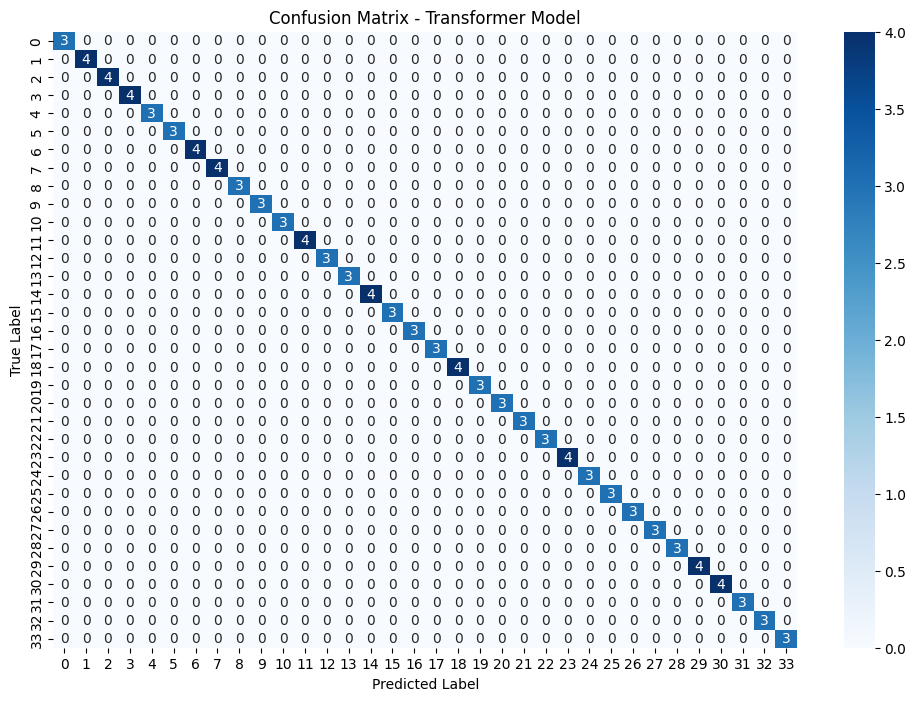

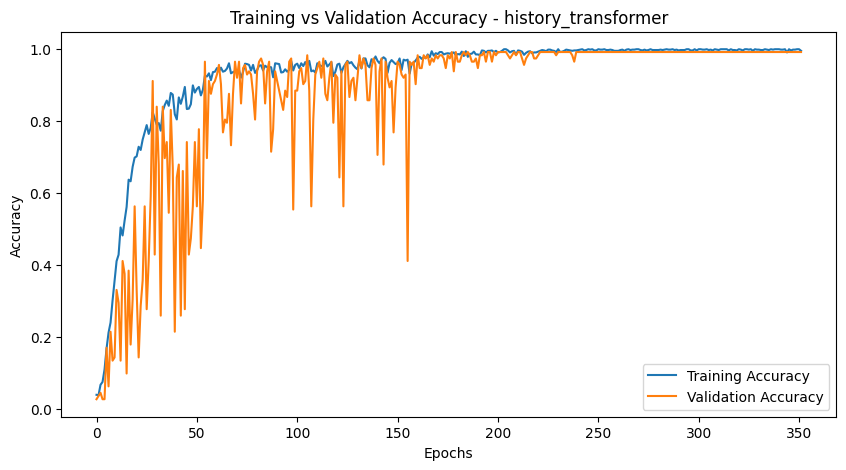

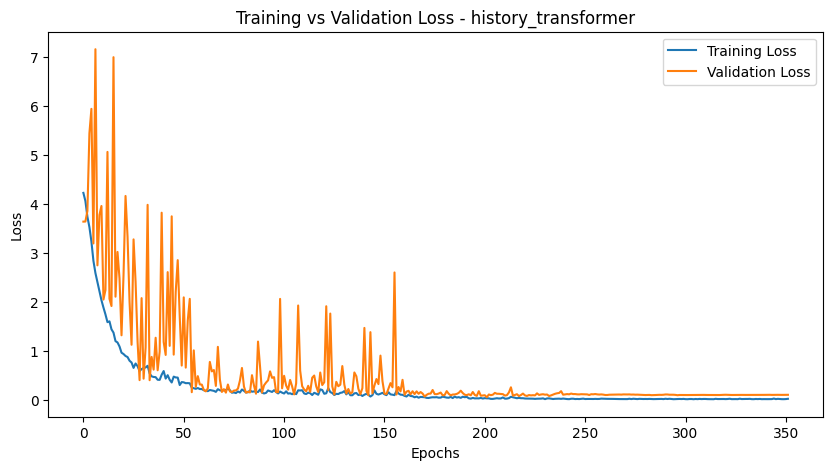

In [23]:
# Defining Transformer block
def transformer_block(x, num_heads=8, key_dim=64, dropout_rate=0.3):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization()(Add()([x, attention]))  # Residual Connection

    ff = Dense(128, activation='relu')(attention)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(x.shape[-1], activation='linear')(ff)  # Match original dim
    x = LayerNormalization()(Add()([attention, ff]))  # Residual Connection
    return x

# Defining input
inputs = Input(shape=(30, 63))

# Transformer layers
x = transformer_block(inputs)
x = transformer_block(x)
x = transformer_block(x)

# Global Average Pooling to flatten sequence
x = GlobalAveragePooling1D()(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Creating Transformer Model
model_transformer = Model(inputs=inputs, outputs=outputs)

# Compiling the model
model_transformer.compile(optimizer=AdamW(learning_rate=1e-3),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=20, factor=0.5, min_lr=1e-6, verbose=1)

# Traiing the model
history_transformer = model_transformer.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[early_stopping, lr_reduction]
)

# Evaluating the model
y_pred_transformer = model_transformer.predict(X_test)
y_pred_classes_transformer = np.argmax(y_pred_transformer, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

test_accuracy_transformer = accuracy_score(y_true_classes, y_pred_classes_transformer)
print(f"Transformer Model - Test Accuracy: {test_accuracy_transformer:.4f}")
print(classification_report(y_true_classes, y_pred_classes_transformer))

# Saving the model
model_transformer.save("/content/drive/MyDrive/BSL_Preprocessed/bsl_transformer.h5")
print("Transformer Model saved.")

# Ploting confusion matrix for Attention-based LSTM Model
plot_confusion_matrix(y_true_classes, y_pred_classes_transformer, "Transformer Model")
# Plotting accuracy and loss
plot_training_history(history_transformer, "history_transformer")

# TESTING MODELS

In [41]:
# Selecting 10 random indices from X_test
random_indices = np.random.choice(len(X_test), 10, replace=False)
sample_sequences = X_test[random_indices]
true_labels = np.argmax(y_test[random_indices], axis=1)  # True labels

# Predictions using all models
models = {
    "Basic LSTM": model_lstm_1,
    "Advanced LSTM": model_lstm_advanced,
    "LSTM + Basic Attention": model_lstm_attention,
    "LSTM + Advanced Attention": model_lstm_attention_v2,
    "Transformer": model_transformer
}

# Iterating through models and generate predictions
for model_name, model in models.items():
    predictions = model.predict(sample_sequences)
    predicted_classes = np.argmax(predictions, axis=1)

    print(f"\nPredictions for {model_name}:")
    for i, (true, pred) in enumerate(zip(true_labels, predicted_classes)):
        print(f"Sample {i+1}: True Class: {true} | Predicted Class: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Predictions for Basic LSTM:
Sample 1: True Class: 29 | Predicted Class: 15
Sample 2: True Class: 18 | Predicted Class: 18
Sample 3: True Class: 32 | Predicted Class: 32
Sample 4: True Class: 33 | Predicted Class: 33
Sample 5: True Class: 16 | Predicted Class: 16
Sample 6: True Class: 29 | Predicted Class: 29
Sample 7: True Class: 8 | Predicted Class: 8
Sample 8: True Class: 9 | Predicted Class: 9
Sample 9: True Class: 32 | Predicted Class: 32
Sample 10: True Class: 0 | Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Predictions for Advanced LSTM:
Sample 1: True Class: 29 | Predicted Class: 29
Sample 2: True Class: 18 | Predicted Class: 18
Sample 3: True Class: 32 | Predicted Class: 32
Sample 4: True Class: 33 | Predicted Class: 33
Sample 5: True Class: 16 | Predicted Class: 16
Sample 6: True Class: 29 | Predicted Class: 29
Sample 7: True Class: 8 | Predicted Class: 8
Sample 8: True Class: 9 | Predicted Class: 9
Sample 9: True Class: 32 |

# This Streamlit UI is not the part of this Notebook

# The Code from Cell bellow have to be used as a seperate .py file.

In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2
import zipfile
import os
from PIL import Image
import mediapipe as mp

# Initialise MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

# Loaing model
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("bsl_lstm_attention_v2.h5")
    return model

model = load_model()

# Mapping class indices to gesture labels
class_mapping = {
    0: "C - c", 1: "Eight - 8", 2: "Five - 5", 3: "Four - 4",
    4: "Nine - 9", 5: "One - 1", 6: "Seven - 7", 7: "Six - 6",
    8: "Three - 3", 9: "Two - 2", 10: "Zero - 0", 11: "A - a",
    12: "B - b", 13: "D - d", 14: "E - e", 15: "F - f",
    16: "G - g", 17: "I - i", 18: "K - k", 19: "L - l",
    20: "M - m", 21: "N - n", 22: "O - o", 23: "P - p",
    24: "Q - q", 25: "R - r", 26: "S - s", 27: "T - t",
    28: "Ten - 10", 29: "U - u", 30: "V - v", 31: "W - w",
    32: "X - x", 33: "Z - z"
}

# Function to extract keypoints from an image
def extract_keypoints(image):
    """Extracts 21 keypoints (x, y, z) from a hand image using MediaPipe."""
    image_rgb = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]  # Getting first detected hand
        return np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
    else:
        return np.zeros(21 * 3)  # If no hand is detected, return zero array

# Streamlit UI
st.markdown("<h1 style='text-align: center; font-size: 40px;'>BSL Gesture Recognition</h1>", unsafe_allow_html=True)
st.markdown("<p style='text-align: center; font-size: 18px;'>Upload a single image or a ZIP folder with 30 frames.</p>", unsafe_allow_html=True)

# File upload options
option = st.radio("Select Input Type:", ("Upload Single Image", "Upload ZIP Folder (30 Frames)"))

if option == "Upload Single Image":
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

    if uploaded_file is not None:
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Uploaded Image", use_column_width=True)

        # Extracting keypoints
        keypoints = extract_keypoints(image)
        sequence = np.array([keypoints] * 30)  # Shape: (30, 63)
        input_data = np.expand_dims(sequence, axis=0)

        # Makeing prediction
        predictions = model.predict(input_data)
        class_index = np.argmax(predictions, axis=1)[0]
        gesture_name = class_mapping.get(class_index, "Unknown Gesture")

        st.success("Model loaded successfully!")
        st.markdown(f"<h2 style='text-align: center; font-size: 32px; color: #4CAF50;'>Predicted Gesture: {gesture_name}</h2>", unsafe_allow_html=True)

elif option == "Upload ZIP Folder (30 Frames)":
    zip_file = st.file_uploader("Upload ZIP folder with 30 images...", type=["zip"])

    if zip_file is not None:
        # Extracting ZIP folder
        extract_path = "temp_frames"
        os.makedirs(extract_path, exist_ok=True)

        with zipfile.ZipFile(zip_file, "r") as zip_ref:
            zip_ref.extractall(extract_path)

        # Getting sorted list of images
        image_files = sorted([os.path.join(extract_path, f) for f in os.listdir(extract_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        # Ensuring to have exactly 30 frames
        if len(image_files) != 30:
            st.error(f"Expected 30 frames, but found {len(image_files)}. Please upload the correct number of images.")
        else:
            st.markdown("<h3 style='text-align: center;'>Uploaded Sequence</h3>", unsafe_allow_html=True)

            # Displaying the first and last frame as preview
            col1, col2 = st.columns(2)
            with col1:
                st.image(image_files[0], caption="First Frame", use_column_width=True)
            with col2:
                st.image(image_files[-1], caption="Last Frame", use_column_width=True)

            # Extracting keypoints for all 30 frames
            sequence = np.array([extract_keypoints(Image.open(img).convert("RGB")) for img in image_files])

            # Ensuring correct shape
            if sequence.shape != (30, 63):
                st.error(f"Incorrect input shape: {sequence.shape}. Ensure images are readable.")
            else:
                # Adding batch dimension (1, 30, 63)
                input_data = np.expand_dims(sequence, axis=0)

                # Making prediction
                predictions = model.predict(input_data)
                class_index = np.argmax(predictions, axis=1)[0]
                gesture_name = class_mapping.get(class_index, "Unknown Gesture")

                st.success("Model loaded successfully!")
                st.markdown(f"<h2 style='text-align: center; font-size: 32px; color: #4CAF50;'>Predicted Gesture: {gesture_name}</h2>", unsafe_allow_html=True)

        # Cleanup extracted images
        for file in image_files:
            os.remove(file)
        os.rmdir(extract_path)